---

#Final Project Section02-Team 7

#Music Genre and Composer Classification Using Deep Learning

#Jason Raimondi, Kwabena Mensah, and Aria Alaghemand

##AAI-511: Neural Networks and Deep Learning

##2023-08-14

###Final Project Section02-Team 7.ipynb

###Data Source:

https://ole.sandiego.edu/bbcswebdav/pid-3097352-dt-content-rid-46201906_1/xid-46201906_1

---

# Data Pre-processing / Feature Extraction

## Install Required Packages

In [ ]:
!pip install pretty_midi --quiet # music analysis package

## Load Required Libraries

In [ ]:
# ignore warnings during code execution
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt # subplots
%matplotlib inline
import numpy as np # array manipulation
import os # operating system interfaces
import pandas as pd # data manipulation
import random # random seed
import sys # system-specific parameters and functions
import tensorflow as tf # deep learning framework
import pretty_midi # music analysis
from sklearn import metrics # metrics module
from sklearn.model_selection import train_test_split # splitter function
from tensorflow import keras # deeplearning API
from keras import Input, Model # functional model
from keras.callbacks import EarlyStopping # early stopping
from keras.layers import Concatenate, Conv1D, Conv2D, Dense, Dropout, Flatten, LSTM, MaxPooling2D # model layer types
from keras.models import Sequential # sequential model
from keras.optimizers import Adam # adam optimizer
from keras.regularizers import L1, L2, L1L2, OrthogonalRegularizer # regularization
from keras.utils import plot_model # visualize model
from sklearn.preprocessing import MinMaxScaler # feature normalization
from zipfile import ZipFile # dataset extraction

In [ ]:
# set global random seeds
seed = 2468
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

## Load Dataset

In [ ]:
# extract dataset from zipped archive
path_dataset = '/content/Composer_Dataset.zip'
with ZipFile(path_dataset, 'r') as myzip:
  myzip.extractall('/content/Data')

# define folder paths for dev, test, and train
folder_dev = '/content/Data/Composer_Dataset/NN_midi_files_extended/dev'
folder_test = '/content/Data/Composer_Dataset/NN_midi_files_extended/test'
folder_train = '/content/Data/Composer_Dataset/NN_midi_files_extended/train'

# add folder paths to list for iteration
folder_list = [folder_dev, folder_test, folder_train]

# iterate through dev, test, and train folders, separate into 3 MIDI file lists per composer
for folder in folder_list:
  if folder.endswith('/dev'):
    midi_set = 'dev'
  elif folder.endswith('/test'):
    midi_set = 'test'
  elif folder.endswith('/train'):
    midi_set = 'train'

# iterate through composer subfolders, create dynamic variables to separate midi file list per composer and per set (e.g., bach_dev, bach_test, bach_train)
  for folder_composer in os.listdir(folder):
    if not folder_composer.startswith('.'):
      dynamic_var = folder_composer + '_' + midi_set
      midi_file_list = []
      for file in os.listdir(folder + '/' + folder_composer):
        if not file.startswith('.'):
          midi_file_list.append(folder + '/' + folder_composer + '/' + file)
      module_name = __name__
      current_module = sys.modules[module_name]
      setattr(current_module, dynamic_var, midi_file_list)

## Build Datasets Function - CNN

In [ ]:
# function to build and return datasets for CNN models
def build_datasets_cnn(composer_name, composer_train, composer_val, composer_test, feature_to_extract, feature_length):

  # variables to reference number of files in each dataset
  num_files_train = len(composer_train)
  num_files_val = len(composer_val)
  num_files_test = len(composer_test)

  # train, val, and test sets prior to adding random samples where class = 0
  composer_train = composer_train.copy()
  composer_val = composer_val.copy()
  composer_test = composer_test.copy()

  # add random samples of class = 0 to equal size of dataset at hand
  for dataset in [composer_train, composer_val, composer_test]:

    # set local variables based on dataset at hand
    if dataset == composer_train:
      directory = folder_train
      num_files = num_files_train
    elif dataset == composer_val:
      directory = folder_dev
      num_files = num_files_val
    elif dataset == composer_test:
      directory = folder_test
      num_files = num_files_test

    # define list of composers for random sampling
    composer_list = os.listdir(directory)
    if composer_name in composer_list:
      composer_list.remove(composer_name)
    if '.DS_Store' in composer_list:
      composer_list.remove('.DS_Store')

    # add random samples of class = 0 until they equal where class = 1 (i.e., current composer)
    for i in range(num_files):
      random_composer = random.choice(composer_list)
      composer_folder = directory + '/' + random_composer
      file_list = os.listdir(composer_folder)
      if '.DS_Store' in file_list:
        file_list.remove('.DS_Store')
      random_file = random.choice(file_list)
      random_file_path = directory + '/' + random_composer + '/' + random_file

      # append to respective dataset
      if dataset == composer_train:
        composer_train.append(random_file_path)
      elif dataset == composer_val:
        composer_val.append(random_file_path)
      elif dataset == composer_test:
        composer_test.append(random_file_path)

  # define arrays to hold new datasets
  new_train = np.empty((0, feature_length))
  new_val = np.empty((0, feature_length))
  new_test = np.empty((0, feature_length))
  y_train = np.empty(0)
  y_val = np.empty(0)
  y_test = np.empty(0)

  # iterate through each dataset
  for dataset in [composer_train, composer_val, composer_test]:
    file_counter = 1

    # assist with monitoring progress through console
    if dataset == composer_train:
      print('Begin processing TRAIN dataset:')
    elif dataset == composer_val:
      print('\nBegin processing VAL dataset:')
    elif dataset == composer_test:
      print('\nBegin processing TEST dataset:')

    # extract chroma feature from each midi file and create labeled datasets
    if feature_to_extract == 'chroma':

      # iterate through midi files of dataset and add reshaped feature to the new dataset
      for midi_file in dataset:
        if file_counter % 5 == 0:
          print('Processing file', file_counter, 'of', len(dataset), end='.\n')
        file_counter+=1
        if composer_name in midi_file:
          label = 1.
        else:
          label = 0.
        chroma = pretty_midi.PrettyMIDI(midi_file).get_chroma()
        resized_chroma = np.empty((0, feature_length))
        for row in chroma:
          resized_chroma = np.append(resized_chroma, np.reshape(row[0:feature_length], (1, feature_length)), axis=0)

        # add to respective dataset
        if dataset == composer_train:
          new_train = np.append(new_train, resized_chroma, axis=0)
          y_train = np.append(y_train, label)
        elif dataset == composer_val:
          new_val = np.append(new_val, resized_chroma, axis=0)
          y_val = np.append(y_val, label)
        elif dataset == composer_test:
          new_test = np.append(new_test, resized_chroma, axis=0)
          y_test = np.append(y_test, label)

  # normalize input values and reshape for modeling tasks
  scaler = MinMaxScaler(feature_range=(0,1), clip=True)
  new_train = np.reshape(scaler.fit_transform(new_train), (-1, 12, feature_length, 1))
  new_val = np.reshape(scaler.transform(new_val), (-1, 12, feature_length, 1))
  new_test = np.reshape(scaler.transform(new_test), (-1, 12, feature_length, 1))

  # verify dataset shapes are what we expect
  assert new_train.shape[1] == 12
  assert new_train.shape[2] == feature_length
  assert new_train.shape[3] == 1
  assert y_train.shape == (num_files_train*2,)
  assert new_val.shape[1] == 12
  assert new_val.shape[2] == feature_length
  assert new_val.shape[3] == 1
  assert y_val.shape == (num_files_val*2,)
  assert new_test.shape[1] == 12
  assert new_test.shape[2] == feature_length
  assert new_test.shape[3] == 1
  assert y_test.shape == (num_files_test*2,)

  # return datasets
  return new_train, y_train, new_val, y_val, new_test, y_test

## Build Datasets Function - LSTM

In [ ]:
# function to build and return datasets for LSTM models
def build_datasets_lstm(composer_name, composer_train, composer_val, composer_test, num_sequences_beats, num_sequences_pitch_class, window_size_beats, window_size_pitch_class):

  # variables to reference number of files in each dataset
  num_files_train = len(composer_train)
  num_files_val = len(composer_val)
  num_files_test = len(composer_test)

  # train, val, and test sets prior to adding random samples where class = 0
  composer_train = composer_train.copy()
  composer_val = composer_val.copy()
  composer_test = composer_test.copy()

  # add random samples of class = 0 to equal size of dataset at hand
  for dataset in [composer_train, composer_val, composer_test]:

    # set local variables based on dataset at hand
    if dataset == composer_train:
      directory = folder_train
      num_files = num_files_train
    elif dataset == composer_val:
      directory = folder_dev
      num_files = num_files_val
    elif dataset == composer_test:
      directory = folder_test
      num_files = num_files_test

    # define list of composers for random sampling
    composer_list = os.listdir(directory)
    if composer_name in composer_list:
      composer_list.remove(composer_name)
    if '.DS_Store' in composer_list:
      composer_list.remove('.DS_Store')

    # add random samples of class = 0 until they equal where class = 1 (i.e., current composer)
    for i in range(num_files):
      random_composer = random.choice(composer_list)
      composer_folder = directory + '/' + random_composer
      file_list = os.listdir(composer_folder)
      if '.DS_Store' in file_list:
        file_list.remove('.DS_Store')
      random_file = random.choice(file_list)
      random_file_path = directory + '/' + random_composer + '/' + random_file

      # append to respective dataset
      if dataset == composer_train:
        composer_train.append(random_file_path)
      elif dataset == composer_val:
        composer_val.append(random_file_path)
      elif dataset == composer_test:
        composer_test.append(random_file_path)

  # define arrays to hold new datasets
  new_train_beats = np.empty(0)
  new_val_beats =  np.empty(0)
  new_test_beats =  np.empty(0)
  new_train_pitch_class = np.empty(0)
  new_val_pitch_class = np.empty(0)
  new_test_pitch_class = np.empty(0)
  y_train = np.empty(0)
  y_val = np.empty(0)
  y_test = np.empty(0)

  # iterate through each dataset
  for dataset in [composer_train, composer_val, composer_test]:
    file_counter = 1

    # assist with monitoring progress through console
    if dataset == composer_train:
      print('Begin processing TRAIN dataset:')
    elif dataset == composer_val:
      print('\nBegin processing VAL dataset:')
    elif dataset == composer_test:
      print('\nBegin processing TEST dataset:')

    # iterate through midi files of dataset and add reshaped feature to the new dataset
    for midi_file in dataset:
      if file_counter % 5 == 0:
        print('Processing file', file_counter, 'of', len(dataset), end='.\n')
      file_counter+=1
      if composer_name in midi_file:
        label = 1.
      else:
        label = 0.

      # obtain and assign features to variables, feature length determined by window sizes and number of sequences chosen
      beats = pretty_midi.PrettyMIDI(midi_file).get_beats()[0:(window_size_beats + (num_sequences_beats-1))]
      pitch_class = np.ndarray.flatten(pretty_midi.PrettyMIDI(midi_file).get_pitch_class_transition_matrix())[0:(window_size_pitch_class + (num_sequences_pitch_class-1))]

      # add to respective dataset
      if dataset == composer_train:
        new_train_beats = np.append(new_train_beats, beats, axis=0)
        new_train_pitch_class = np.append(new_train_pitch_class, pitch_class, axis=0)
        y_train = np.append(y_train, label)
      elif dataset == composer_val:
        new_val_beats = np.append(new_val_beats, beats, axis=0)
        new_val_pitch_class = np.append(new_val_pitch_class, pitch_class, axis=0)
        y_val = np.append(y_val, label)
      elif dataset == composer_test:
        new_test_beats = np.append(new_test_beats, beats, axis=0)
        new_test_pitch_class = np.append(new_test_pitch_class, pitch_class, axis=0)
        y_test = np.append(y_test, label)

  # normalize input values
  scaler = MinMaxScaler(feature_range=(0,1), clip=True)
  new_train_beats = scaler.fit_transform(np.reshape(new_train_beats, (-1, 1)))
  new_val_beats = scaler.transform(np.reshape(new_val_beats, (-1, 1)))
  new_test_beats = scaler.transform(np.reshape(new_test_beats, (-1, 1)))
  new_train_pitch_class = scaler.fit_transform(np.reshape(new_train_pitch_class, (-1, 1)))
  new_val_pitch_class = scaler.transform(np.reshape(new_val_pitch_class, (-1, 1)))
  new_test_pitch_class = scaler.transform(np.reshape(new_test_pitch_class, (-1, 1)))

  # reshape input values back into desired matrix sizes for further processing
  new_train_beats = new_train_beats.squeeze()
  new_train_beats = new_train_beats.reshape(len(composer_train), len(beats))
  new_val_beats = new_val_beats.squeeze()
  new_val_beats = new_val_beats.reshape(len(composer_val), len(beats))
  new_test_beats = new_test_beats.squeeze()
  new_test_beats = new_test_beats.reshape(len(composer_test), len(beats))
  new_train_pitch_class = new_train_pitch_class.squeeze()
  new_train_pitch_class = new_train_pitch_class.reshape(len(composer_train), len(pitch_class))
  new_val_pitch_class = new_val_pitch_class.squeeze()
  new_val_pitch_class = new_val_pitch_class.reshape(len(composer_val), len(pitch_class))
  new_test_pitch_class = new_test_pitch_class.squeeze()
  new_test_pitch_class = new_test_pitch_class.reshape(len(composer_test), len(pitch_class))

  # iterate through each dataset for the beats feature
  for dataset_beats in ['new_train_beats', 'new_val_beats', 'new_test_beats']:

    # prepare empty datasets of desired sizes to append feature sequences to
    if dataset_beats == 'new_train_beats':
      current_dataset = new_train_beats
      new_train_beats = np.empty((0, num_sequences_beats, window_size_beats, 1))
    elif dataset_beats == 'new_val_beats':
      current_dataset = new_val_beats
      new_val_beats =  np.empty((0, num_sequences_beats, window_size_beats, 1))
    elif dataset_beats == 'new_test_beats':
      current_dataset = new_test_beats
      new_test_beats =  np.empty((0, num_sequences_beats, window_size_beats, 1))

    # iterate through each dataset sample for sequence building
    for sample in range(current_dataset.shape[0]):

      # define empty array for reshaping beats feature
      reshaped_beats = np.empty((0, num_sequences_beats, window_size_beats))

      # build sequences for beats
      current_matrix = np.empty((0, window_size_beats))
      for i in range(window_size_beats, (len(beats)+1)):
        current_sequence = current_dataset[sample][i-window_size_beats:i]
        current_matrix = np.append(current_matrix, np.reshape(current_sequence, (1, -1)), axis=0)
      reshaped_beats = np.append(reshaped_beats, np.reshape(current_matrix, (1, num_sequences_beats, window_size_beats)), axis=0)

      # update respective dataset
      if dataset_beats == 'new_train_beats':
        new_train_beats = np.append(new_train_beats, np.reshape(reshaped_beats, (-1, num_sequences_beats, window_size_beats, 1)), axis=0)
      elif dataset_beats == 'new_val_beats':
        new_val_beats = np.append(new_val_beats, np.reshape(reshaped_beats, (-1, num_sequences_beats, window_size_beats, 1)), axis=0)
      elif dataset_beats == 'new_test_beats':
        new_test_beats = np.append(new_test_beats, np.reshape(reshaped_beats, (-1, num_sequences_beats, window_size_beats, 1)), axis=0)

  # iterate through each dataset for the pitch class feature
  for dataset_pitch_class in ['new_train_pitch_class', 'new_val_pitch_class', 'new_test_pitch_class']:

    # prepare empty datasets of desired sizes to append feature sequences to
    if dataset_pitch_class == 'new_train_pitch_class':
      current_dataset = new_train_pitch_class
      new_train_pitch_class = np.empty((0, num_sequences_pitch_class, window_size_pitch_class, 1))
    elif dataset_pitch_class == 'new_val_pitch_class':
      current_dataset = new_val_pitch_class
      new_val_pitch_class = np.empty((0, num_sequences_pitch_class, window_size_pitch_class, 1))
    elif dataset_pitch_class == 'new_test_pitch_class':
      current_dataset = new_test_pitch_class
      new_test_pitch_class = np.empty((0, num_sequences_pitch_class, window_size_pitch_class, 1))

    # iterate through each dataset sample for sequence building
    for sample in range(current_dataset.shape[0]):

      # define empty array for reshaping pitch class feature
      reshaped_pitch_class = np.empty((0, num_sequences_pitch_class, window_size_pitch_class))

      # build sequences for pitch class
      current_matrix = np.empty((0, window_size_pitch_class))
      for i in range(window_size_pitch_class, (len(pitch_class)+1)):
        current_sequence = current_dataset[sample][i-window_size_pitch_class:i]
        current_matrix = np.append(current_matrix, np.reshape(current_sequence, (1, -1)), axis=0)
      reshaped_pitch_class = np.append(reshaped_pitch_class, np.reshape(current_matrix, (1, num_sequences_pitch_class, window_size_pitch_class)), axis=0)

      # update respective dataset
      if dataset_pitch_class == 'new_train_pitch_class':
        new_train_pitch_class = np.append(new_train_pitch_class, np.reshape(reshaped_pitch_class, (-1, num_sequences_pitch_class, window_size_pitch_class, 1)), axis=0)
      elif dataset_pitch_class == 'new_val_pitch_class':
        new_val_pitch_class = np.append(new_val_pitch_class, np.reshape(reshaped_pitch_class, (-1, num_sequences_pitch_class, window_size_pitch_class, 1)), axis=0)
      elif dataset_pitch_class == 'new_test_pitch_class':
        new_test_pitch_class = np.append(new_test_pitch_class, np.reshape(reshaped_pitch_class, (-1, num_sequences_pitch_class, window_size_pitch_class, 1)), axis=0)

  # verify beats dataset shapes are what we expect
  assert new_train_beats.shape[1] == num_sequences_beats
  assert new_train_beats.shape[2] == window_size_beats
  assert new_train_beats.shape[3] == 1
  assert new_val_beats.shape[1] == num_sequences_beats
  assert new_val_beats.shape[2] == window_size_beats
  assert new_val_beats.shape[3] == 1
  assert new_test_beats.shape[1] == num_sequences_beats
  assert new_test_beats.shape[2] == window_size_beats
  assert new_test_beats.shape[3] == 1

  # verify pitch class dataset shapes are what we expect
  assert new_train_pitch_class.shape[1] == num_sequences_pitch_class
  assert new_train_pitch_class.shape[2] == window_size_pitch_class
  assert new_train_pitch_class.shape[3] == 1
  assert new_val_pitch_class.shape[1] == num_sequences_pitch_class
  assert new_val_pitch_class.shape[2] == window_size_pitch_class
  assert new_val_pitch_class.shape[3] == 1
  assert new_test_pitch_class.shape[1] == num_sequences_pitch_class
  assert new_test_pitch_class.shape[2] == window_size_pitch_class
  assert new_test_pitch_class.shape[3] == 1

  # verify output label shapes are what we expect
  assert y_train.shape == (num_files_train*2,)
  assert y_val.shape == (num_files_val*2,)
  assert y_test.shape == (num_files_test*2,)

  # return datasets
  return new_train_beats, new_train_pitch_class, y_train, new_val_beats, new_val_pitch_class, y_val, new_test_beats, new_test_pitch_class, y_test

## Build Confusion Matrix Function

In [ ]:
# define function to construct confusion matrix
def build_confusion_matrix(model, description, x_train, x_test, y_train, y_test):

  # for CNN models
  if isinstance(model, Sequential):

    # calculate y_hat
    y_hat = model.predict(x_train, batch_size=1)
    y_hat = np.argmax(y_hat, axis=1)

    # calculate y_pred
    y_pred = model.predict(x_test, batch_size=1)
    y_pred = np.argmax(y_pred, axis=1)

  # for LSTM models
  elif isinstance(model, Model):

    # calculate y_hat
    y_hat = model.predict((x_train[0], x_train[1]), batch_size=1)
    y_hat = np.argmax(y_hat, axis=1)

    # calculate y_pred
    y_pred = model.predict((x_test[0], x_test[1]), batch_size=1)
    y_pred = np.argmax(y_pred, axis=1)

  # calculate train and test accuracy
  score_accuracy_train = metrics.accuracy_score(y_train, y_hat)
  score_accuracy_test = metrics.accuracy_score(y_test, y_pred)

  # calculate precision
  score_precision = metrics.precision_score(y_test, y_pred)

  # calculate recall
  score_recall = metrics.recall_score(y_test, y_pred)

  # calculate f1 score
  score_f1 = metrics.f1_score(y_test, y_pred)

  # print metrics
  print(description,'\n')
  print('Train Accuracy:', '{:.2%}'.format(score_accuracy_train))
  print('Test Accuracy:', '{:.2%}'.format(score_accuracy_test))
  print('Precision:', '{:.2%}'.format(score_precision))
  print('Recall:', '{:.2%}'.format(score_recall))
  print('F1 Score:', '{:.2%}'.format(score_f1))

  # build and display confusion matrix
  disp = metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
  fig = disp.ax_.get_figure()
  fig.set_figwidth(4)
  fig.set_figheight(4)
  plt.title('Confusion Matrix')
  plt.suptitle(description)
  plt.show()

  # return metrics
  return score_accuracy_train, score_accuracy_test, score_precision, score_recall, score_f1

## Feature Visualization Example

### Chroma - Bach, Chopin, and Mozart

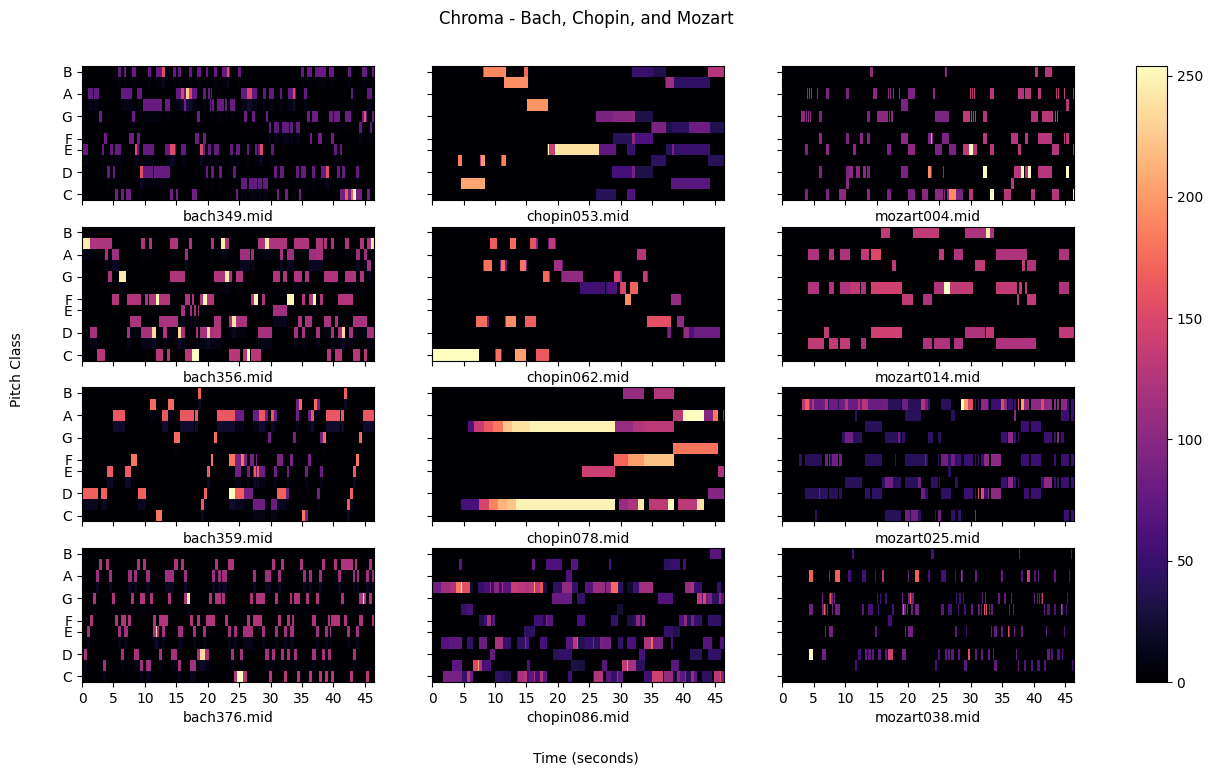

In [ ]:
# define midi files for each composer
midi_files_bach = [folder_test + '/bach/bach349.mid', folder_test + '/bach/bach356.mid', folder_test + '/bach/bach359.mid', folder_test + '/bach/bach376.mid']
midi_files_chopin = [folder_test + '/chopin/chopin053.mid', folder_test + '/chopin/chopin062.mid', folder_test + '/chopin/chopin078.mid', folder_test + '/chopin/chopin086.mid']
midi_files_mozart = [folder_test + '/mozart/mozart004.mid', folder_test + '/mozart/mozart014.mid', folder_test + '/mozart/mozart025.mid', folder_test + '/mozart/mozart038.mid']

# define empty arrays to hold chroma feature
chroma_bach = np.empty((0, 12, 2000))
chroma_chopin = np.empty((0, 12, 2000))
chroma_mozart = np.empty((0, 12, 2000))

# obtain chroma feature for bach
for i in range(len(midi_files_bach)):
  chroma_temp = pretty_midi.PrettyMIDI(midi_files_bach[i]).get_chroma()
  resized_chroma = np.empty((0, 2000))
  for row in chroma_temp:
    resized_chroma = np.append(resized_chroma, np.reshape(row[0:2000], (1, 2000)), axis=0)
  chroma_bach = np.append(chroma_bach, np.reshape(resized_chroma, (1, 12, 2000)), axis=0)

# obtain chroma feature for chopin
for i in range(len(midi_files_chopin)):
  chroma_temp = pretty_midi.PrettyMIDI(midi_files_chopin[i]).get_chroma()
  resized_chroma = np.empty((0, 2000))
  for row in chroma_temp:
    resized_chroma = np.append(resized_chroma, np.reshape(row[0:2000], (1, 2000)), axis=0)
  chroma_chopin = np.append(chroma_chopin, np.reshape(resized_chroma, (1, 12, 2000)), axis=0)

# obtain chroma feature for mozart
for i in range(len(midi_files_mozart)):
  chroma_temp = pretty_midi.PrettyMIDI(midi_files_mozart[i]).get_chroma()
  resized_chroma = np.empty((0, 2000))
  for row in chroma_temp:
    resized_chroma = np.append(resized_chroma, np.reshape(row[0:2000], (1, 2000)), axis=0)
  chroma_mozart = np.append(chroma_mozart, np.reshape(resized_chroma, (1, 12, 2000)), axis=0)

# display visualization
fig, axs = plt.subplots(nrows=4, ncols=3, sharex=True, sharey=True, figsize=(16, 8))
for i in range(4):
  img = librosa.display.specshow(chroma_bach[i], x_axis='s', y_axis='chroma', ax=axs[i,0])
  librosa.display.specshow(chroma_chopin[i], x_axis='s', y_axis='chroma', ax=axs[i,1])
  librosa.display.specshow(chroma_mozart[i], x_axis='s', y_axis='chroma', ax=axs[i,2])
  axs[i,0].set(xlabel=midi_files_bach[i].split('/')[-1], ylabel='')
  axs[i,1].set(xlabel=midi_files_chopin[i].split('/')[-1], ylabel='')
  axs[i,2].set(xlabel=midi_files_mozart[i].split('/')[-1], ylabel='')
fig.colorbar(img, ax=axs)
fig.text(0.44, 0.01, 'Time (seconds)', ha='center')
fig.text(0.08, 0.50, 'Pitch Class', va='center', rotation='vertical')
fig.suptitle('Chroma - Bach, Chopin, and Mozart', x=0.44, y=0.95)
plt.show()

### Chroma - Hummel Train, Validation, and Test

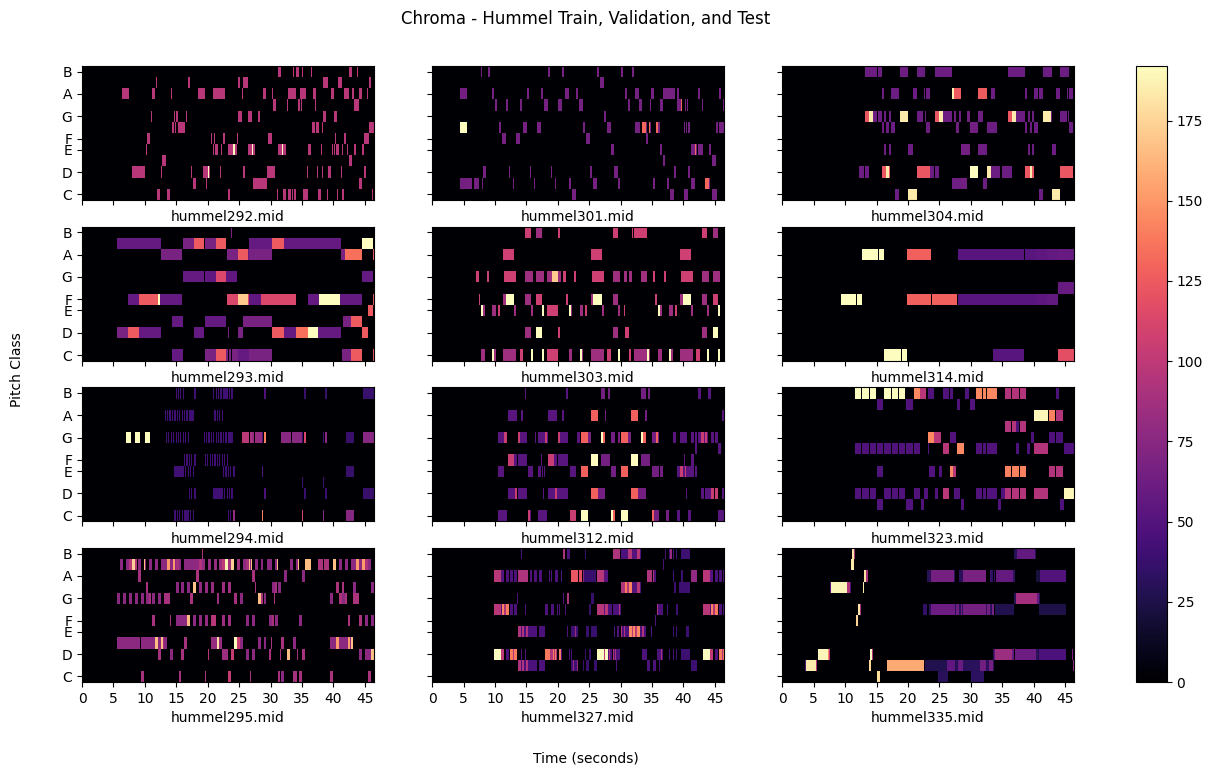

In [ ]:
# define midi files for each composer
midi_files_htrain = [folder_train + '/hummel/hummel292.mid', folder_train + '/hummel/hummel293.mid', folder_train + '/hummel/hummel294.mid', folder_train + '/hummel/hummel295.mid']
midi_files_hval = [folder_dev + '/hummel/hummel301.mid', folder_dev + '/hummel/hummel303.mid', folder_dev + '/hummel/hummel312.mid', folder_dev + '/hummel/hummel327.mid']
midi_files_htest = [folder_test + '/hummel/hummel304.mid', folder_test + '/hummel/hummel314.mid', folder_test + '/hummel/hummel323.mid', folder_test + '/hummel/hummel335.mid']

# define empty arrays to hold chroma feature
chroma_htrain = np.empty((0, 12, 2000))
chroma_hval = np.empty((0, 12, 2000))
chroma_htest = np.empty((0, 12, 2000))

# obtain chroma feature for hummel - train dataset
for i in range(len(midi_files_htrain)):
  chroma_temp = pretty_midi.PrettyMIDI(midi_files_htrain[i]).get_chroma()
  resized_chroma = np.empty((0, 2000))
  for row in chroma_temp:
    resized_chroma = np.append(resized_chroma, np.reshape(row[0:2000], (1, 2000)), axis=0)
  chroma_htrain = np.append(chroma_htrain, np.reshape(resized_chroma, (1, 12, 2000)), axis=0)

# obtain chroma feature for hummel - validation dataset
for i in range(len(midi_files_hval)):
  chroma_temp = pretty_midi.PrettyMIDI(midi_files_hval[i]).get_chroma()
  resized_chroma = np.empty((0, 2000))
  for row in chroma_temp:
    resized_chroma = np.append(resized_chroma, np.reshape(row[0:2000], (1, 2000)), axis=0)
  chroma_hval = np.append(chroma_hval, np.reshape(resized_chroma, (1, 12, 2000)), axis=0)

# obtain chroma feature for hummel - test dataset
for i in range(len(midi_files_htest)):
  chroma_temp = pretty_midi.PrettyMIDI(midi_files_htest[i]).get_chroma()
  resized_chroma = np.empty((0, 2000))
  for row in chroma_temp:
    resized_chroma = np.append(resized_chroma, np.reshape(row[0:2000], (1, 2000)), axis=0)
  chroma_htest = np.append(chroma_htest, np.reshape(resized_chroma, (1, 12, 2000)), axis=0)

# display visualization
fig, axs = plt.subplots(nrows=4, ncols=3, sharex=True, sharey=True, figsize=(16, 8))
for i in range(4):
  img = librosa.display.specshow(chroma_htrain[i], x_axis='s', y_axis='chroma', ax=axs[i,0])
  librosa.display.specshow(chroma_hval[i], x_axis='s', y_axis='chroma', ax=axs[i,1])
  librosa.display.specshow(chroma_htest[i], x_axis='s', y_axis='chroma', ax=axs[i,2])
  axs[i,0].set(xlabel=midi_files_htrain[i].split('/')[-1], ylabel='')
  axs[i,1].set(xlabel=midi_files_hval[i].split('/')[-1], ylabel='')
  axs[i,2].set(xlabel=midi_files_htest[i].split('/')[-1], ylabel='')
fig.colorbar(img, ax=axs)
fig.text(0.44, 0.01, 'Time (seconds)', ha='center')
fig.text(0.08, 0.50, 'Pitch Class', va='center', rotation='vertical')
fig.suptitle('Chroma - Hummel Train, Validation, and Test', x=0.44, y=0.95)
plt.show()

# Model Building (Per Composer)

## Mozart - CNN (Jason)

### Split Datasets

In [ ]:
# call function to build and split datasets
x_train, y_train, x_val, y_val, x_test, y_test = build_datasets_cnn(composer_name = 'mozart',
                                                                    composer_train = mozart_train,
                                                                    composer_val = mozart_dev,
                                                                    composer_test = mozart_test,
                                                                    feature_to_extract = 'chroma',
                                                                    feature_length = 2000)

# print input shape to go into cnn model
print('\nInput Shape for Training:')
print('x_train:', x_train.shape)

Begin processing TRAIN dataset:
Processing file 5 of 82.
Processing file 10 of 82.
Processing file 15 of 82.
Processing file 20 of 82.
Processing file 25 of 82.
Processing file 30 of 82.
Processing file 35 of 82.
Processing file 40 of 82.
Processing file 45 of 82.
Processing file 50 of 82.
Processing file 55 of 82.
Processing file 60 of 82.
Processing file 65 of 82.
Processing file 70 of 82.
Processing file 75 of 82.
Processing file 80 of 82.

Begin processing VAL dataset:
Processing file 5 of 8.

Begin processing TEST dataset:
Processing file 5 of 8.

Input Shape for Training:
x_train: (82, 12, 2000, 1)


### Build, Train, and Optimize

Epoch 1/25
6/6 [==============================] - 1s 110ms/step - loss: 0.7112 - accuracy: 0.4512 - val_loss: 0.6557 - val_accuracy: 0.5000
Epoch 2/25
6/6 [==============================] - 2s 340ms/step - loss: 0.5293 - accuracy: 0.7317 - val_loss: 0.6683 - val_accuracy: 0.5000
Epoch 3/25
6/6 [==============================] - 0s 72ms/step - loss: 0.4398 - accuracy: 0.8537 - val_loss: 0.6822 - val_accuracy: 0.5000
Epoch 4/25
6/6 [==============================] - 2s 345ms/step - loss: 0.3752 - accuracy: 0.8902 - val_loss: 0.7148 - val_accuracy: 0.5000
Epoch 5/25
6/6 [==============================] - 0s 76ms/step - loss: 0.3469 - accuracy: 0.8415 - val_loss: 0.6969 - val_accuracy: 0.5000
Epoch 6/25
6/6 [==============================] - 1s 99ms/step - loss: 0.2718 - accuracy: 0.9268 - val_loss: 0.6691 - val_accuracy: 0.5000
Epoch 7/25
6/6 [==============================] - 1s 198ms/step - loss: 0.2414 - accuracy: 0.9512 - val_loss: 0.6894 - val_accuracy: 0.5000
Epoch 8/25
6/6 [=======

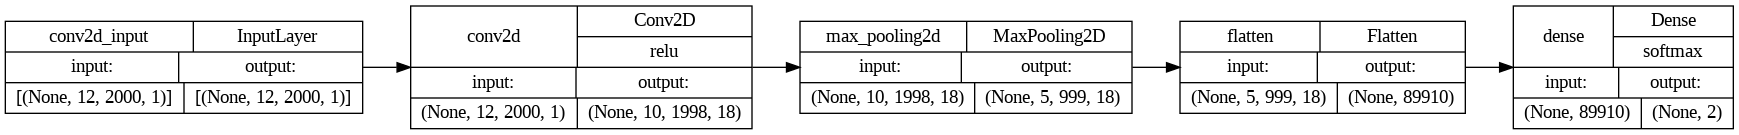

In [ ]:
# define input shape
input_shape = (x_train.shape[1], x_train.shape[2], x_train.shape[3])

# mozart cnn - define the cnn model
model_mozart_cnn = Sequential([
    Conv2D(18, (3,3), activation='relu', input_shape=input_shape),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(2, activation='softmax') # 2 units for binary classification using softmax
])

# mozart cnn - compile the model
model_mozart_cnn.compile(optimizer=Adam(learning_rate=0.001),
                         loss='sparse_categorical_crossentropy', # sparse categorical crossentropy loss function
                         metrics=['accuracy'])

# early stopping callback if learning stalls
callback = EarlyStopping(monitor='loss', patience=3)

# mozart cnn - train the model
model_mozart_cnn.fit(x_train, y_train, batch_size=16, epochs=25, callbacks=[callback], validation_data=(x_val, y_val))

# mozart cnn - evaluate the model on the test set
test_loss, test_acc = model_mozart_cnn.evaluate(x_test, y_test)
print('\nTest accuracy:', "{:.4%}".format(test_acc), '\n')

# plot model visualization
plot_model(model_mozart_cnn, to_file='model_mozart_cnn.png', show_shapes=True, rankdir='LR', show_layer_activations=True)

### Evaluate

8/8 [==============================] - 1s 193ms/step
Mozart - CNN 

Train Accuracy: 100.00%
Test Accuracy: 100.00%
Precision: 100.00%
Recall: 100.00%
F1 Score: 100.00%


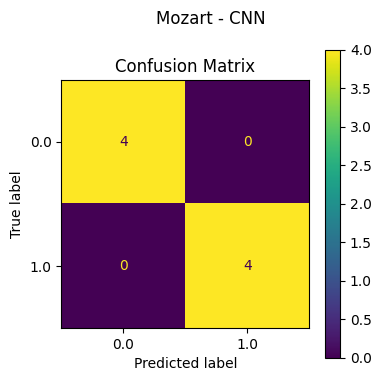

In [ ]:
# mozart cnn - call function to build confusion matrix
mozart_cnn_score_accuracy_train, mozart_cnn_score_accuracy_test, mozart_cnn_score_precision, mozart_cnn_score_recall, mozart_cnn_score_f1 = build_confusion_matrix(
    model=model_mozart_cnn, description='Mozart - CNN', x_train=x_train, x_test=x_test, y_train=y_train, y_test=y_test)

## Mozart - LSTM (Jason)

### Split Datasets

In [ ]:
# call function to build and split datasets
x_train1, x_train2, y_train, x_val1, x_val2, y_val, x_test1, x_test2, y_test = build_datasets_lstm(composer_name = 'mozart',
                                                                                                   composer_train = mozart_train,
                                                                                                   composer_val = mozart_dev,
                                                                                                   composer_test = mozart_test,
                                                                                                   num_sequences_beats = 16,
                                                                                                   num_sequences_pitch_class = 12,
                                                                                                   window_size_beats=15,
                                                                                                   window_size_pitch_class=12)

# print input shape to go into lstm model
print('\nInput Shapes for Training:')
print('x_train1:', x_train1.shape)
print('x_train2:', x_train2.shape)

Begin processing TRAIN dataset:
Processing file 5 of 82.
Processing file 10 of 82.
Processing file 15 of 82.
Processing file 20 of 82.
Processing file 25 of 82.
Processing file 30 of 82.
Processing file 35 of 82.
Processing file 40 of 82.
Processing file 45 of 82.
Processing file 50 of 82.
Processing file 55 of 82.
Processing file 60 of 82.
Processing file 65 of 82.
Processing file 70 of 82.
Processing file 75 of 82.
Processing file 80 of 82.

Begin processing VAL dataset:
Processing file 5 of 8.

Begin processing TEST dataset:
Processing file 5 of 8.

Input Shapes for Training:
x_train1: (82, 16, 15, 1)
x_train2: (82, 12, 12, 1)


### Build, Train, and Optimize

Epoch 1/35
6/6 [==============================] - 6s 136ms/step - loss: 0.7189 - accuracy: 0.5000 - val_loss: 0.7154 - val_accuracy: 0.5000
Epoch 2/35
6/6 [==============================] - 1s 98ms/step - loss: 0.7187 - accuracy: 0.4878 - val_loss: 0.7142 - val_accuracy: 0.5000
Epoch 3/35
6/6 [==============================] - 0s 56ms/step - loss: 0.7158 - accuracy: 0.6707 - val_loss: 0.7148 - val_accuracy: 0.7500
Epoch 4/35
6/6 [==============================] - 0s 84ms/step - loss: 0.7150 - accuracy: 0.6707 - val_loss: 0.7108 - val_accuracy: 0.6250
Epoch 5/35
6/6 [==============================] - 0s 49ms/step - loss: 0.7107 - accuracy: 0.7317 - val_loss: 0.7085 - val_accuracy: 0.7500
Epoch 6/35
6/6 [==============================] - 0s 49ms/step - loss: 0.7067 - accuracy: 0.7561 - val_loss: 0.7025 - val_accuracy: 0.6250
Epoch 7/35
6/6 [==============================] - 0s 37ms/step - loss: 0.7052 - accuracy: 0.7561 - val_loss: 0.7028 - val_accuracy: 0.7500
Epoch 8/35
6/6 [==========

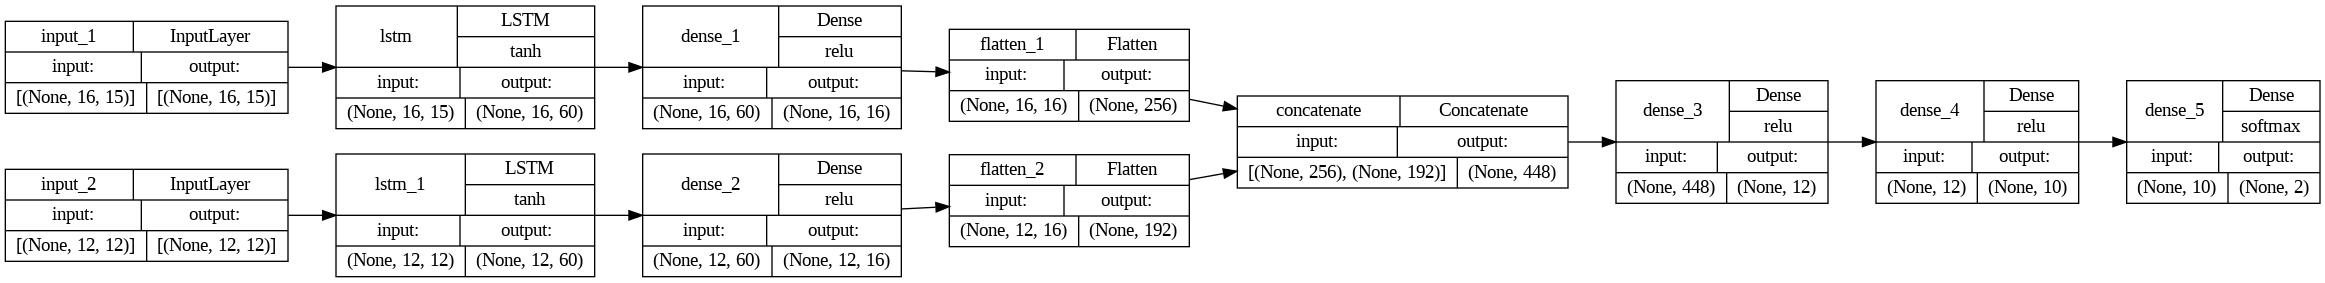

In [ ]:
# define input shapes for each feature
input_shape1 = (x_train1.shape[1], x_train1.shape[2]) # beats
input_shape2 = (x_train2.shape[1], x_train2.shape[2]) # pitch class

# define layers for first input - beats
input1 = Input(shape=(input_shape1))
lstm1 = LSTM(units=60, dropout=0.1, recurrent_dropout=0.01, return_sequences=True)(input1)
dense1 = Dense(units=16, activation='relu', kernel_regularizer=L1(0.0001))(lstm1)
flat1 = Flatten()(dense1)

# define layers for second input - pitch class
input2 = Input(shape=(input_shape2))
lstm2 = LSTM(units=60, dropout=0.1, recurrent_dropout=0.01, return_sequences=True)(input2)
dense2 = Dense(units=16, activation='relu', kernel_regularizer=L1(0.0001))(lstm2)
flat2 = Flatten()(dense2)

# concatenate inputs/layers together
inputs_concat = Concatenate(axis=1)([flat1, flat2])

# build remainder layers to output
dense3 = Dense(12, activation='relu')(inputs_concat)
dense4 = Dense(10, activation='relu')(dense3)
output = Dense(2, activation='softmax')(dense4)

# construct model
model_mozart_lstm = Model(inputs=[input1, input2], outputs=output)

# mozart lstm - compile the model
model_mozart_lstm.compile(
              optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy', # sparse categorical crossentropy loss function
              metrics=['accuracy'])

# early stopping callback if learning stalls
callback = EarlyStopping(monitor='loss', patience=3)

# mozart lstm - train the model
model_mozart_lstm.fit((x_train1, x_train2), y_train, batch_size=16, epochs=35, callbacks=[callback], validation_data=((x_val1, x_val2), y_val))

# mozart lstm - evaluate the model on the test set
test_loss, test_acc = model_mozart_lstm.evaluate((x_test1, x_test2), y_test)
print('\nTest accuracy:', "{:.4%}".format(test_acc), '\n')

# plot model visualization
plot_model(model_mozart_lstm, to_file='model_mozart_lstm.png', show_shapes=True, rankdir='LR', show_layer_activations=True)

### Evaluate

8/8 [==============================] - 0s 4ms/step
Mozart - LSTM 

Train Accuracy: 78.05%
Test Accuracy: 62.50%
Precision: 66.67%
Recall: 50.00%
F1 Score: 57.14%


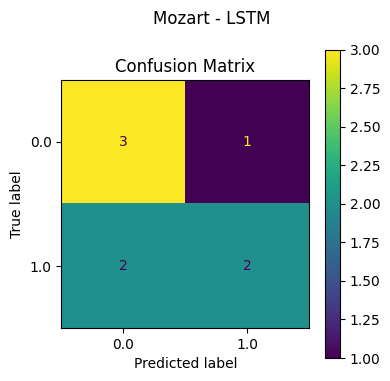

In [ ]:
# mozart lstm - call function to build confusion matrix
mozart_lstm_score_accuracy_train, mozart_lstm_score_accuracy_test, mozart_lstm_score_precision, mozart_lstm_score_recall, mozart_lstm_score_f1 = build_confusion_matrix(
    model=model_mozart_lstm, description='Mozart - LSTM', x_train=(x_train1, x_train2), x_test=(x_test1, x_test2), y_train=y_train, y_test=y_test)

## Schumann - CNN (Jason)

### Split Datasets

In [ ]:
# call function to build and split datasets
x_train, y_train, x_val, y_val, x_test, y_test = build_datasets_cnn(composer_name = 'schumann',
                                                                    composer_train = schumann_train,
                                                                    composer_val = schumann_dev,
                                                                    composer_test = schumann_test,
                                                                    feature_to_extract = 'chroma',
                                                                    feature_length = 2000)

# print input shape to go into cnn model
print('\nInput Shape for Training:')
print('x_train:', x_train.shape)

Begin processing TRAIN dataset:
Processing file 5 of 76.
Processing file 10 of 76.
Processing file 15 of 76.
Processing file 20 of 76.
Processing file 25 of 76.
Processing file 30 of 76.
Processing file 35 of 76.
Processing file 40 of 76.
Processing file 45 of 76.
Processing file 50 of 76.
Processing file 55 of 76.
Processing file 60 of 76.
Processing file 65 of 76.
Processing file 70 of 76.
Processing file 75 of 76.

Begin processing VAL dataset:
Processing file 5 of 6.

Begin processing TEST dataset:
Processing file 5 of 6.

Input Shape for Training:
x_train: (76, 12, 2000, 1)


### Build, Train, and Optimize

Epoch 1/25
1/1 [==============================] - 3s 3s/step - loss: 1.0110 - accuracy: 0.5000 - val_loss: 0.8097 - val_accuracy: 0.5000
Epoch 2/25
1/1 [==============================] - 1s 1s/step - loss: 0.9778 - accuracy: 0.5000 - val_loss: 0.7994 - val_accuracy: 0.5000
Epoch 3/25
1/1 [==============================] - 1s 1s/step - loss: 0.9477 - accuracy: 0.5000 - val_loss: 0.7889 - val_accuracy: 0.5000
Epoch 4/25
1/1 [==============================] - 2s 2s/step - loss: 0.9211 - accuracy: 0.5132 - val_loss: 0.7798 - val_accuracy: 0.5000
Epoch 5/25
1/1 [==============================] - 1s 931ms/step - loss: 0.8976 - accuracy: 0.5789 - val_loss: 0.7725 - val_accuracy: 0.5000
Epoch 6/25
1/1 [==============================] - 1s 879ms/step - loss: 0.8761 - accuracy: 0.6053 - val_loss: 0.7668 - val_accuracy: 0.5000
Epoch 7/25
1/1 [==============================] - 1s 1s/step - loss: 0.8563 - accuracy: 0.6447 - val_loss: 0.7626 - val_accuracy: 0.5000
Epoch 8/25
1/1 [===================

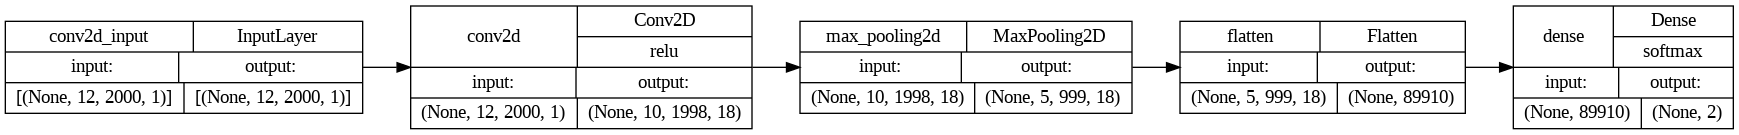

In [ ]:
# define input shape
input_shape = (x_train.shape[1], x_train.shape[2], x_train.shape[3])

# schumann cnn - define the cnn model
model_schumann_cnn = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=input_shape, activity_regularizer=L2(0.001), kernel_regularizer=L2(0.001)),
    MaxPooling2D((2,2)),
    Conv2D(18, (2,2), activation='relu', activity_regularizer=L2(0.001), kernel_regularizer=L2(0.001)),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(2, activation='softmax') # 2 units for binary classification using softmax
])

# schumann cnn - compile the model
model_schumann_cnn.compile(optimizer=Adam(learning_rate=0.0008),
              loss='sparse_categorical_crossentropy', # sparse categorical crossentropy loss function
              metrics=['accuracy'])

# early stopping callback if learning stalls
callback = EarlyStopping(monitor='loss', patience=3)

# schumann cnn - train the model
model_schumann_cnn.fit(x_train, y_train, batch_size=136, epochs=25, callbacks=[callback], validation_data=(x_val, y_val))

# schumann cnn - evaluate the model on the test set
test_loss, test_acc = model_schumann_cnn.evaluate(x_test, y_test)
print('\nTest accuracy:', "{:.4%}".format(test_acc), '\n')

# plot model visualization
plot_model(model_mozart_cnn, to_file='model_schumann_cnn.png', show_shapes=True, rankdir='LR', show_layer_activations=True)

### Evaluate

6/6 [==============================] - 0s 5ms/step
Schumann - CNN 

Train Accuracy: 85.53%
Test Accuracy: 33.33%
Precision: 33.33%
Recall: 33.33%
F1 Score: 33.33%


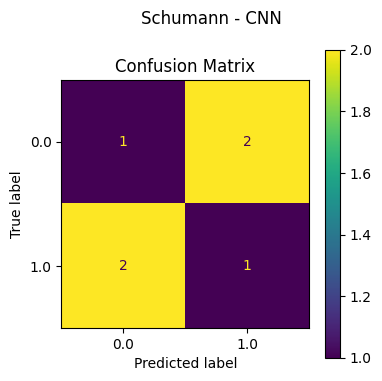

In [ ]:
# schumann cnn - call function to build confusion matrix
schumann_cnn_score_accuracy_train, schumann_cnn_score_accuracy_test, schumann_cnn_score_precision, schumann_cnn_score_recall, schumann_cnn_score_f1 = build_confusion_matrix(
    model=model_schumann_cnn, description='Schumann - CNN', x_train=x_train, x_test=x_test, y_train=y_train, y_test=y_test)

## Schumann - LSTM (Jason)

### Split Datasets

In [ ]:
# call function to build and split datasets
x_train1, x_train2, y_train, x_val1, x_val2, y_val, x_test1, x_test2, y_test = build_datasets_lstm(composer_name = 'schumann',
                                                                                                   composer_train = schumann_train,
                                                                                                   composer_val = schumann_dev,
                                                                                                   composer_test = schumann_test,
                                                                                                   num_sequences_beats = 16,
                                                                                                   num_sequences_pitch_class = 12,
                                                                                                   window_size_beats=15,
                                                                                                   window_size_pitch_class=12)

# print input shape to go into lstm model
print('\nInput Shapes for Training:')
print('x_train1:', x_train1.shape)
print('x_train2:', x_train2.shape)

Begin processing TRAIN dataset:
Processing file 5 of 76.
Processing file 10 of 76.
Processing file 15 of 76.
Processing file 20 of 76.
Processing file 25 of 76.
Processing file 30 of 76.
Processing file 35 of 76.
Processing file 40 of 76.
Processing file 45 of 76.
Processing file 50 of 76.
Processing file 55 of 76.
Processing file 60 of 76.
Processing file 65 of 76.
Processing file 70 of 76.
Processing file 75 of 76.

Begin processing VAL dataset:
Processing file 5 of 6.

Begin processing TEST dataset:
Processing file 5 of 6.

Input Shapes for Training:
x_train1: (76, 16, 15, 1)
x_train2: (76, 12, 12, 1)


### Build, Train, and Optimize

Epoch 1/25
10/10 [==============================] - 4s 143ms/step - loss: 0.7955 - accuracy: 0.5000 - val_loss: 0.7846 - val_accuracy: 0.5000
Epoch 2/25
10/10 [==============================] - 0s 15ms/step - loss: 0.7831 - accuracy: 0.5132 - val_loss: 0.7766 - val_accuracy: 0.5000
Epoch 3/25
10/10 [==============================] - 0s 13ms/step - loss: 0.7736 - accuracy: 0.4737 - val_loss: 0.7689 - val_accuracy: 0.5000
Epoch 4/25
10/10 [==============================] - 0s 21ms/step - loss: 0.7652 - accuracy: 0.5000 - val_loss: 0.7615 - val_accuracy: 0.6667
Epoch 5/25
10/10 [==============================] - 0s 22ms/step - loss: 0.7578 - accuracy: 0.4868 - val_loss: 0.7548 - val_accuracy: 0.5000
Epoch 6/25
10/10 [==============================] - 0s 22ms/step - loss: 0.7508 - accuracy: 0.5132 - val_loss: 0.7484 - val_accuracy: 0.5000
Epoch 7/25
10/10 [==============================] - 0s 20ms/step - loss: 0.7436 - accuracy: 0.5000 - val_loss: 0.7437 - val_accuracy: 0.5000
Epoch 8/25
1

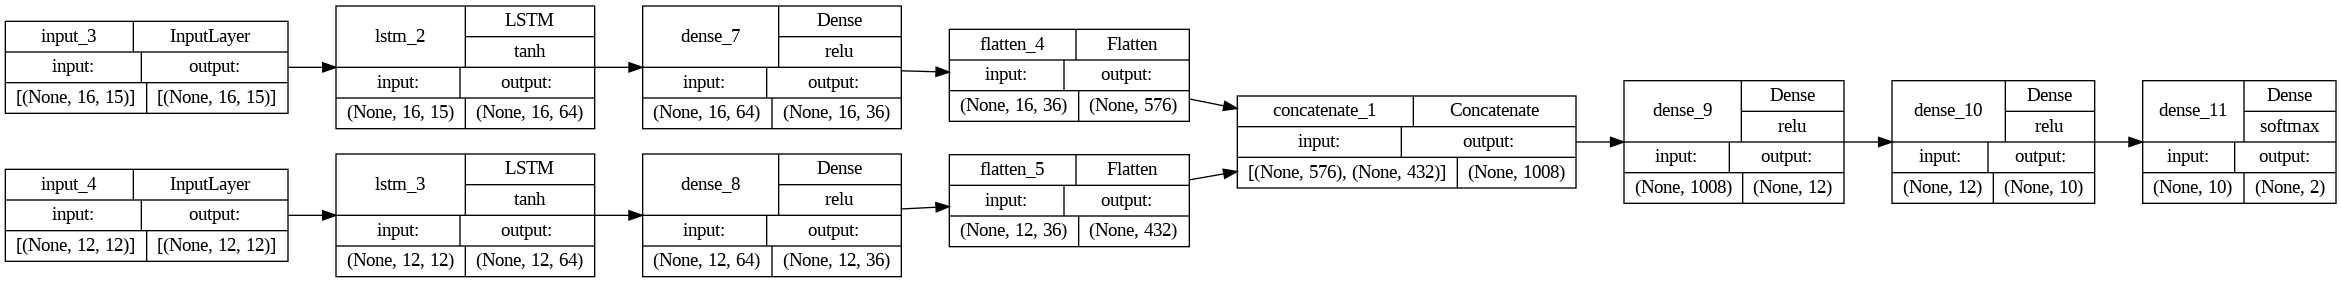

In [ ]:
# define input shapes for each feature
input_shape1 = (x_train1.shape[1], x_train1.shape[2]) # beats
input_shape2 = (x_train2.shape[1], x_train2.shape[2]) # pitch class

# define layers for first input - beats
input1 = Input(shape=(input_shape1))
lstm1 = LSTM(units=64, dropout=0.1, return_sequences=True)(input1)
dense1 = Dense(units=36, activation='relu', kernel_regularizer=L2(0.0011))(lstm1)
flat1 = Flatten()(dense1)

# define layers for second input - pitch class
input2 = Input(shape=(input_shape2))
lstm2 = LSTM(units=64, dropout=0.1, return_sequences=True)(input2)
dense2 = Dense(units=36, activation='relu', kernel_regularizer=L2(0.0011))(lstm2)
flat2 = Flatten()(dense2)

# concatenate inputs/layers together
inputs_concat = Concatenate(axis=1)([flat1, flat2])

# build remainder layers to output
dense3 = Dense(12, activation='relu')(inputs_concat)
dense4 = Dense(10, activation='relu')(dense3)
output = Dense(2, activation='softmax')(dense4)

# construct model
model_schumann_lstm = Model(inputs=[input1, input2], outputs=output)

# schumann lstm - compile the model
model_schumann_lstm.compile(
              optimizer=Adam(learning_rate=0.0009),
              loss='sparse_categorical_crossentropy', # sparse categorical crossentropy loss function
              metrics=['accuracy'])

# early stopping callback if learning stalls
callback = EarlyStopping(monitor='loss', patience=3)

# schumann lstm - train the model
model_schumann_lstm.fit((x_train1, x_train2), y_train, batch_size=8, epochs=25, callbacks=[callback], validation_data=((x_val1, x_val2), y_val))

# schumann lstm - evaluate the model on the test set
test_loss, test_acc = model_schumann_lstm.evaluate((x_test1, x_test2), y_test)
print('\nTest accuracy:', "{:.4%}".format(test_acc), '\n')

# plot model visualization
plot_model(model_schumann_lstm, to_file='model_schumann_lstm.png', show_shapes=True, rankdir='LR', show_layer_activations=True)

### Evaluate

6/6 [==============================] - 0s 38ms/step
Schumann - LSTM 

Train Accuracy: 53.95%
Test Accuracy: 33.33%
Precision: 0.00%
Recall: 0.00%
F1 Score: 0.00%


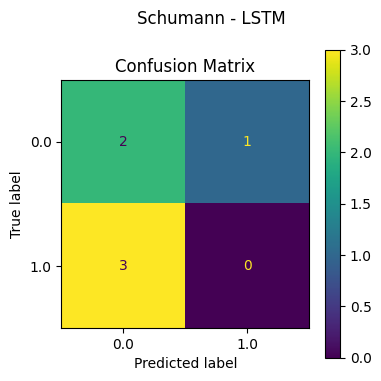

In [ ]:
# schumann lstm - call function to build confusion matrix
schumann_lstm_score_accuracy_train, schumann_lstm_score_accuracy_test, schumann_lstm_score_precision, schumann_lstm_score_recall, schumann_lstm_score_f1 = build_confusion_matrix(
    model=model_schumann_lstm, description='Schumann - LSTM', x_train=(x_train1, x_train2), x_test=(x_test1, x_test2), y_train=y_train, y_test=y_test)

## Mendelssohn - CNN (Jason)

### Split Datasets

In [ ]:
# call function to build and split datasets
x_train, y_train, x_val, y_val, x_test, y_test = build_datasets_cnn(composer_name = 'mendelssohn',
                                                                    composer_train = mendelssohn_train,
                                                                    composer_val = mendelssohn_dev,
                                                                    composer_test = mendelssohn_test,
                                                                    feature_to_extract = 'chroma',
                                                                    feature_length = 2500)

# print input shape to go into cnn model
print('\nInput Shape for Training:')
print('x_train:', x_train.shape)

Begin processing TRAIN dataset:
Processing file 5 of 82.
Processing file 10 of 82.
Processing file 15 of 82.
Processing file 20 of 82.
Processing file 25 of 82.
Processing file 30 of 82.
Processing file 35 of 82.
Processing file 40 of 82.
Processing file 45 of 82.
Processing file 50 of 82.
Processing file 55 of 82.
Processing file 60 of 82.
Processing file 65 of 82.
Processing file 70 of 82.
Processing file 75 of 82.
Processing file 80 of 82.

Begin processing VAL dataset:
Processing file 5 of 8.

Begin processing TEST dataset:
Processing file 5 of 8.

Input Shape for Training:
x_train: (82, 12, 2500, 1)


### Build, Train, and Optimize

Epoch 1/25
3/3 [==============================] - 2s 437ms/step - loss: 0.7605 - accuracy: 0.5610 - val_loss: 0.6353 - val_accuracy: 0.5000
Epoch 2/25
3/3 [==============================] - 3s 1s/step - loss: 0.5131 - accuracy: 0.7561 - val_loss: 0.6838 - val_accuracy: 0.3750
Epoch 3/25
3/3 [==============================] - 1s 362ms/step - loss: 0.4137 - accuracy: 0.8293 - val_loss: 0.7079 - val_accuracy: 0.5000
Epoch 4/25
3/3 [==============================] - 2s 642ms/step - loss: 0.3487 - accuracy: 0.8902 - val_loss: 0.7480 - val_accuracy: 0.6250
Epoch 5/25
3/3 [==============================] - 1s 299ms/step - loss: 0.3223 - accuracy: 0.8902 - val_loss: 0.7807 - val_accuracy: 0.5000
Epoch 6/25
3/3 [==============================] - 2s 609ms/step - loss: 0.2668 - accuracy: 0.9146 - val_loss: 0.8684 - val_accuracy: 0.3750
Epoch 7/25
3/3 [==============================] - 2s 688ms/step - loss: 0.2392 - accuracy: 0.9146 - val_loss: 0.8444 - val_accuracy: 0.3750
Epoch 8/25
3/3 [=======

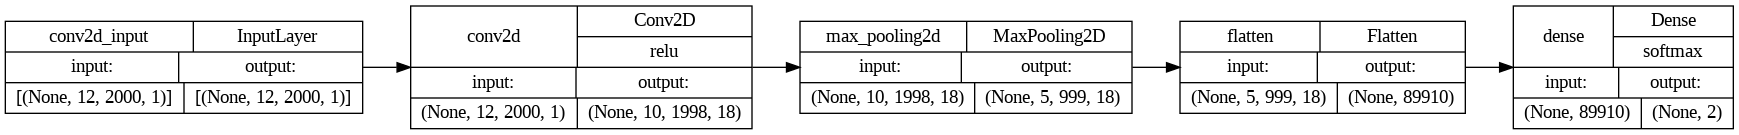

In [ ]:
# define input shape
input_shape = (x_train.shape[1], x_train.shape[2], x_train.shape[3])

# mendelssohn cnn - define the cnn model
model_mendelssohn_cnn = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
    MaxPooling2D((2,2)),
    Dropout(0.1),
    Flatten(),
    Dense(2, activation='softmax') # 2 units for binary classification using softmax
])

# mendelssohn cnn - compile the model
model_mendelssohn_cnn.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy', # sparse categorical crossentropy loss function
              metrics=['accuracy'])

# early stopping callback if learning stalls
callback = EarlyStopping(monitor='loss', patience=3)

# mendelssohn cnn - train the model
model_mendelssohn_cnn.fit(x_train, y_train, batch_size=32, epochs=25, callbacks=[callback], validation_data=(x_val, y_val))

# mendelssohn cnn - evaluate the model on the test set
test_loss, test_acc = model_mendelssohn_cnn.evaluate(x_test, y_test)
print('\nTest accuracy:', "{:.4%}".format(test_acc), '\n')

# plot model visualization
plot_model(model_mozart_cnn, to_file='model_schumann_cnn.png', show_shapes=True, rankdir='LR', show_layer_activations=True)

### Evaluate

8/8 [==============================] - 1s 177ms/step
Mendelssohn - CNN 

Train Accuracy: 100.00%
Test Accuracy: 62.50%
Precision: 57.14%
Recall: 100.00%
F1 Score: 72.73%


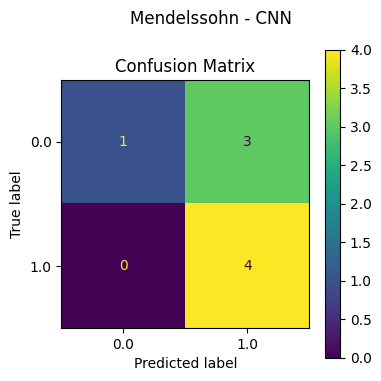

In [ ]:
# mendelssohn cnn - call function to build confusion matrix
mendelssohn_cnn_score_accuracy_train, mendelssohn_cnn_score_accuracy_test, mendelssohn_cnn_score_precision, mendelssohn_cnn_score_recall, mendelssohn_cnn_score_f1 = build_confusion_matrix(
    model=model_mendelssohn_cnn, description='Mendelssohn - CNN', x_train=x_train, x_test=x_test, y_train=y_train, y_test=y_test)

## Mendelssohn - LSTM (Jason)

### Split Datasets

In [ ]:
# call function to build and split datasets
x_train1, x_train2, y_train, x_val1, x_val2, y_val, x_test1, x_test2, y_test = build_datasets_lstm(composer_name = 'mendelssohn',
                                                                                                   composer_train = mendelssohn_train,
                                                                                                   composer_val = mendelssohn_dev,
                                                                                                   composer_test = mendelssohn_test,
                                                                                                   num_sequences_beats = 24,
                                                                                                   num_sequences_pitch_class = 24,
                                                                                                   window_size_beats=16,
                                                                                                   window_size_pitch_class=12)

# print input shape to go into lstm model
print('\nInput Shapes for Training:')
print('x_train1:', x_train1.shape)
print('x_train2:', x_train2.shape)

Begin processing TRAIN dataset:
Processing file 5 of 82.
Processing file 10 of 82.
Processing file 15 of 82.
Processing file 20 of 82.
Processing file 25 of 82.
Processing file 30 of 82.
Processing file 35 of 82.
Processing file 40 of 82.
Processing file 45 of 82.
Processing file 50 of 82.
Processing file 55 of 82.
Processing file 60 of 82.
Processing file 65 of 82.
Processing file 70 of 82.
Processing file 75 of 82.
Processing file 80 of 82.

Begin processing VAL dataset:
Processing file 5 of 8.

Begin processing TEST dataset:
Processing file 5 of 8.

Input Shapes for Training:
x_train1: (82, 24, 16, 1)
x_train2: (82, 24, 12, 1)


### Build, Train, and Optimize

Epoch 1/25
3/3 [==============================] - 5s 433ms/step - loss: 0.6940 - accuracy: 0.4878 - val_loss: 0.6975 - val_accuracy: 0.5000
Epoch 2/25
3/3 [==============================] - 0s 29ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6981 - val_accuracy: 0.5000
Epoch 3/25
3/3 [==============================] - 0s 33ms/step - loss: 0.6926 - accuracy: 0.4878 - val_loss: 0.6951 - val_accuracy: 0.5000
Epoch 4/25
3/3 [==============================] - 0s 27ms/step - loss: 0.6918 - accuracy: 0.5122 - val_loss: 0.6946 - val_accuracy: 0.5000
Epoch 5/25
3/3 [==============================] - 0s 28ms/step - loss: 0.6920 - accuracy: 0.5488 - val_loss: 0.6962 - val_accuracy: 0.5000
Epoch 6/25
3/3 [==============================] - 0s 29ms/step - loss: 0.6919 - accuracy: 0.4756 - val_loss: 0.6976 - val_accuracy: 0.5000
Epoch 7/25
3/3 [==============================] - 0s 31ms/step - loss: 0.6912 - accuracy: 0.4512 - val_loss: 0.6985 - val_accuracy: 0.5000
Epoch 8/25
3/3 [==========

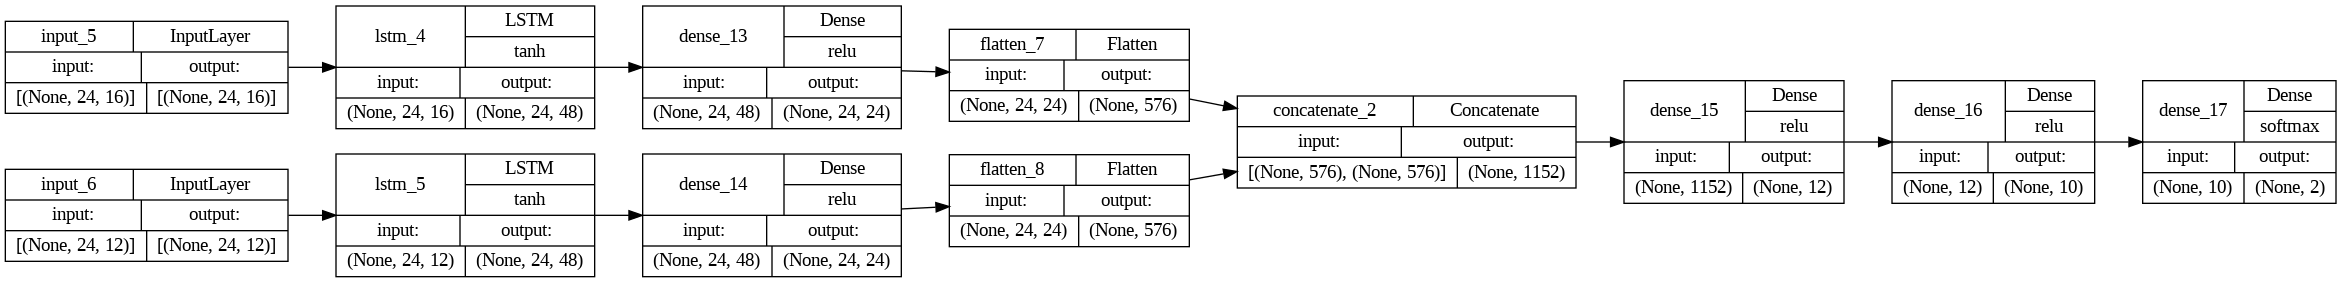

In [ ]:
# define input shapes for each feature
input_shape1 = (x_train1.shape[1], x_train1.shape[2]) # beats
input_shape2 = (x_train2.shape[1], x_train2.shape[2]) # pitch class

# define layers for first input - beats
input1 = Input(shape=(input_shape1))
lstm1 = LSTM(units=48, dropout=0.1, return_sequences=True)(input1)
dense1 = Dense(units=24, activation='relu')(lstm1)
flat1 = Flatten()(dense1)

# define layers for second input - pitch class
input2 = Input(shape=(input_shape2))
lstm2 = LSTM(units=48, dropout=0.1, return_sequences=True)(input2)
dense2 = Dense(units=24, activation='relu')(lstm2)
flat2 = Flatten()(dense2)

# concatenate inputs/layers together
inputs_concat = Concatenate(axis=1)([flat1, flat2])

# build remainder layers to output
dense3 = Dense(12, activation='relu')(inputs_concat)
dense4 = Dense(10, activation='relu')(dense3)
output = Dense(2, activation='softmax')(dense4)

# construct model
model_mendelssohn_lstm = Model(inputs=[input1, input2], outputs=output)

# mendelssohn lstm - compile the model
model_mendelssohn_lstm.compile(
              optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy', # sparse categorical crossentropy loss function
              metrics=['accuracy'])

# early stopping callback if learning stalls
callback = EarlyStopping(monitor='loss', patience=3)

# mendelssohn lstm - train the model
model_mendelssohn_lstm.fit((x_train1, x_train2), y_train, batch_size=32, epochs=25, callbacks=[callback], validation_data=((x_val1, x_val2), y_val))

# mendelssohn lstm - evaluate the model on the test set
test_loss, test_acc = model_mendelssohn_lstm.evaluate((x_test1, x_test2), y_test)
print('\nTest accuracy:', "{:.4%}".format(test_acc), '\n')

# plot model visualization
plot_model(model_mendelssohn_lstm, to_file='model_mendelssohn_lstm.png', show_shapes=True, rankdir='LR', show_layer_activations=True)

### Evaluate

8/8 [==============================] - 0s 3ms/step
Mendelssohn - LSTM 

Train Accuracy: 67.07%
Test Accuracy: 75.00%
Precision: 100.00%
Recall: 50.00%
F1 Score: 66.67%


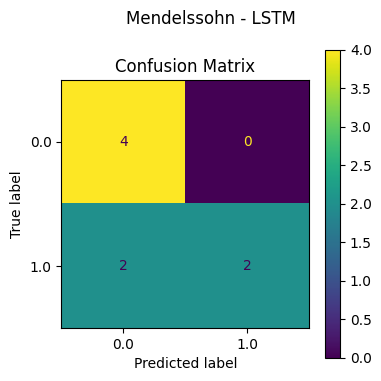

In [ ]:
# mendelssohn lstm - call function to build confusion matrix
mendelssohn_lstm_score_accuracy_train, mendelssohn_lstm_score_accuracy_test, mendelssohn_lstm_score_precision, mendelssohn_lstm_score_recall, mendelssohn_lstm_score_f1 = build_confusion_matrix(
    model=model_mendelssohn_lstm, description='Mendelssohn - LSTM', x_train=(x_train1, x_train2), x_test=(x_test1, x_test2), y_train=y_train, y_test=y_test)

## Bach - CNN (Kobe)

### Split Datasets

In [ ]:
# call function to build and split datasets
x_train, y_train, x_val, y_val, x_test, y_test = build_datasets_cnn(composer_name = 'bach',
                                                                    composer_train = bach_train,
                                                                    composer_val = bach_dev,
                                                                    composer_test = bach_test,
                                                                    feature_to_extract = 'chroma',
                                                                    feature_length = 2000)

# print input shape to go into cnn model
print('\nInput Shape for Training:')
print('x_train:', x_train.shape)

Begin processing TRAIN dataset:
Processing file 5 of 84.
Processing file 10 of 84.
Processing file 15 of 84.
Processing file 20 of 84.
Processing file 25 of 84.
Processing file 30 of 84.
Processing file 35 of 84.
Processing file 40 of 84.
Processing file 45 of 84.
Processing file 50 of 84.
Processing file 55 of 84.
Processing file 60 of 84.
Processing file 65 of 84.
Processing file 70 of 84.
Processing file 75 of 84.
Processing file 80 of 84.

Begin processing VAL dataset:
Processing file 5 of 8.

Begin processing TEST dataset:
Processing file 5 of 8.

Input Shape for Training:
x_train: (84, 12, 2000, 1)


### Build, Train, and Optimize

Epoch 1/25
3/3 [==============================] - 3s 752ms/step - loss: 0.9197 - accuracy: 0.5000 - val_loss: 1.6137 - val_accuracy: 0.5000
Epoch 2/25
3/3 [==============================] - 3s 1s/step - loss: 1.0253 - accuracy: 0.5357 - val_loss: 0.8416 - val_accuracy: 0.5000
Epoch 3/25
3/3 [==============================] - 1s 205ms/step - loss: 0.7871 - accuracy: 0.5238 - val_loss: 0.9622 - val_accuracy: 0.5000
Epoch 4/25
3/3 [==============================] - 1s 561ms/step - loss: 0.5521 - accuracy: 0.7381 - val_loss: 1.0160 - val_accuracy: 0.5000
Epoch 5/25
3/3 [==============================] - 1s 250ms/step - loss: 0.4973 - accuracy: 0.6786 - val_loss: 1.2007 - val_accuracy: 0.5000
Epoch 6/25
3/3 [==============================] - 1s 546ms/step - loss: 0.3825 - accuracy: 0.7619 - val_loss: 0.8501 - val_accuracy: 0.6250
Epoch 7/25
3/3 [==============================] - 1s 562ms/step - loss: 0.3211 - accuracy: 0.9524 - val_loss: 0.7459 - val_accuracy: 0.5000
Epoch 8/25
3/3 [=======

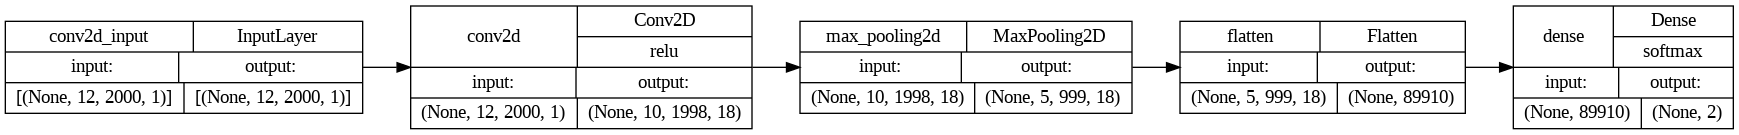

In [ ]:
# define input shape
input_shape = (x_train.shape[1], x_train.shape[2], x_train.shape[3])

# bach cnn - define the cnn model
model_bach_cnn = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
    MaxPooling2D((2,2)),
    #Dropout(.1),
    Flatten(),
    Dense(2, activation='softmax') # 2 units for binary classification using softmax
])

# bach cnn - compile the model
model_bach_cnn.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy', # sparse categorical crossentropy loss function
              metrics=['accuracy'])

# early stopping callback if learning stalls
callback = EarlyStopping(monitor='loss', patience=3)

# bach cnn - train the model
model_bach_cnn.fit(x_train, y_train, batch_size=32, epochs=25, callbacks=[callback], validation_data=(x_val, y_val))

# bach cnn - evaluate the model on the test set
test_loss, test_acc = model_bach_cnn.evaluate(x_test, y_test)
print('\nTest accuracy:', "{:.4%}".format(test_acc), '\n')

# plot model visualization
plot_model(model_mozart_cnn, to_file='model_schumann_cnn.png', show_shapes=True, rankdir='LR', show_layer_activations=True)

### Evaluate

8/8 [==============================] - 0s 4ms/step
Bach - CNN 

Train Accuracy: 100.00%
Test Accuracy: 50.00%
Precision: 50.00%
Recall: 75.00%
F1 Score: 60.00%


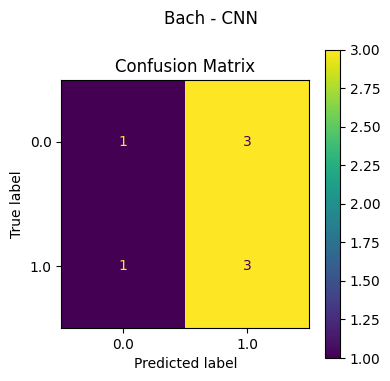

In [ ]:
# bach cnn - call function to build confusion matrix
bach_cnn_score_accuracy_train, bach_cnn_score_accuracy_test, bach_cnn_score_precision, bach_cnn_score_recall, bach_cnn_score_f1 = build_confusion_matrix(
    model=model_bach_cnn, description='Bach - CNN', x_train=x_train, x_test=x_test, y_train=y_train, y_test=y_test)

### Optimize

#### Split Datasets

In [ ]:
# call function to build and split datasets
x_train, y_train, x_val, y_val, x_test, y_test = build_datasets_cnn(composer_name = 'bach',
                                                                    composer_train = bach_train,
                                                                    composer_val = bach_dev,
                                                                    composer_test = bach_test,
                                                                    feature_to_extract = 'chroma',
                                                                    feature_length = 1000)

# print input shape to go into cnn model
print('\nInput Shape for Training:')
print('x_train:', x_train.shape)

Begin processing TRAIN dataset:
Processing file 5 of 84.
Processing file 10 of 84.
Processing file 15 of 84.
Processing file 20 of 84.
Processing file 25 of 84.
Processing file 30 of 84.
Processing file 35 of 84.
Processing file 40 of 84.
Processing file 45 of 84.
Processing file 50 of 84.
Processing file 55 of 84.
Processing file 60 of 84.
Processing file 65 of 84.
Processing file 70 of 84.
Processing file 75 of 84.
Processing file 80 of 84.

Begin processing VAL dataset:
Processing file 5 of 8.

Begin processing TEST dataset:
Processing file 5 of 8.

Input Shape for Training:
x_train: (84, 12, 1000, 1)


#### Build, Train, and Optimize

Epoch 1/25
3/3 [==============================] - 2s 299ms/step - loss: 1.2977 - accuracy: 0.5476 - val_loss: 0.6532 - val_accuracy: 0.5000
Epoch 2/25
3/3 [==============================] - 1s 193ms/step - loss: 2.1571 - accuracy: 0.7262 - val_loss: 0.6586 - val_accuracy: 0.5000
Epoch 3/25
3/3 [==============================] - 1s 178ms/step - loss: 0.2974 - accuracy: 0.9048 - val_loss: 0.7623 - val_accuracy: 0.5000
Epoch 4/25
3/3 [==============================] - 1s 205ms/step - loss: 0.8725 - accuracy: 0.7738 - val_loss: 0.7779 - val_accuracy: 0.5000
Epoch 5/25
3/3 [==============================] - 1s 178ms/step - loss: 0.2557 - accuracy: 0.8810 - val_loss: 0.7117 - val_accuracy: 0.5000
Epoch 6/25
3/3 [==============================] - 1s 180ms/step - loss: 0.2079 - accuracy: 0.9286 - val_loss: 0.6788 - val_accuracy: 0.6250
Epoch 7/25
3/3 [==============================] - 1s 304ms/step - loss: 0.1155 - accuracy: 0.9643 - val_loss: 0.6711 - val_accuracy: 0.6250
Epoch 8/25
3/3 [====

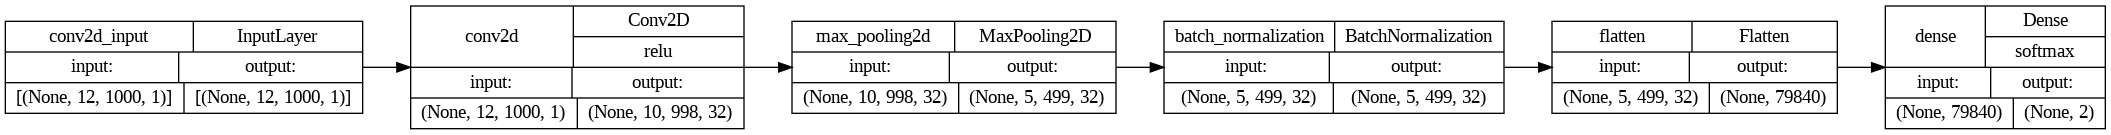

In [ ]:
# define input shape
input_shape = (x_train.shape[1], x_train.shape[2], x_train.shape[3])

# bach cnn - define the cnn model
model_bach_cnn = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
    MaxPooling2D((2,2)),
    tf.keras.layers.BatchNormalization(),
    #Dropout(.1),
    Flatten(),
    Dense(2, activation='softmax') # 2 units for binary classification using softmax
])

# bach cnn - compile the model
model_bach_cnn.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy', # sparse categorical crossentropy loss function
              metrics=['accuracy'])

# early stopping callback if learning stalls
callback = EarlyStopping(monitor='loss', patience=3)

# bach cnn - train the model
model_bach_cnn.fit(x_train, y_train, batch_size=32, epochs=25, callbacks=[callback], validation_data=(x_val, y_val))

# bach cnn - evaluate the model on the test set
test_loss, test_acc = model_bach_cnn.evaluate(x_test, y_test)
print('\nTest accuracy:', "{:.4%}".format(test_acc), '\n')

# plot model visualization
plot_model(model_bach_cnn, to_file='model_bach_cnn.png', show_shapes=True, rankdir='LR', show_layer_activations=True)

In [ ]:
model_bach_cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 10, 998, 32)       320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 5, 499, 32)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 5, 499, 32)       128       
 ormalization)                                                   
                                                                 
 flatten (Flatten)           (None, 79840)             0         
                                                                 
 dense (Dense)               (None, 2)                 159682    
                                                                 
Total params: 160,130
Trainable params: 160,066
Non-trai

#### Evaluate

8/8 [==============================] - 0s 6ms/step
Bach - CNN 

Train Accuracy: 100.00%
Test Accuracy: 37.50%
Precision: 0.00%
Recall: 0.00%
F1 Score: 0.00%


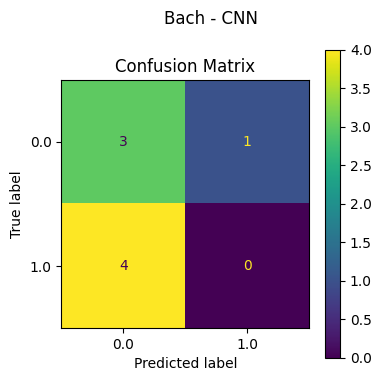

In [ ]:
# bach cnn - call function to build confusion matrix
bach_cnn_score_accuracy_train, bach_cnn_score_accuracy_test, bach_cnn_score_precision, bach_cnn_score_recall, bach_cnn_score_f1 = build_confusion_matrix(
    model=model_bach_cnn, description='Bach - CNN', x_train=x_train, x_test=x_test, y_train=y_train, y_test=y_test)

## Bach - LSTM (Kobe)

### Split Datasets

In [ ]:
# call function to build and split datasets
x_train1, x_train2, y_train, x_val1, x_val2, y_val, x_test1, x_test2, y_test = build_datasets_lstm(composer_name = 'bach',
                                                                                                   composer_train = bach_train,
                                                                                                   composer_val = bach_dev,
                                                                                                   composer_test = bach_test,
                                                                                                   num_sequences_beats = 16,
                                                                                                   num_sequences_pitch_class = 12,
                                                                                                   window_size_beats=15,
                                                                                                   window_size_pitch_class=12)

# print input shape to go into lstm model
print('\nInput Shapes for Training:')
print('x_train1:', x_train1.shape)
print('x_train2:', x_train2.shape)

Begin processing TRAIN dataset:
Processing file 5 of 84.
Processing file 10 of 84.
Processing file 15 of 84.
Processing file 20 of 84.
Processing file 25 of 84.
Processing file 30 of 84.
Processing file 35 of 84.
Processing file 40 of 84.
Processing file 45 of 84.
Processing file 50 of 84.
Processing file 55 of 84.
Processing file 60 of 84.
Processing file 65 of 84.
Processing file 70 of 84.
Processing file 75 of 84.
Processing file 80 of 84.

Begin processing VAL dataset:
Processing file 5 of 8.

Begin processing TEST dataset:
Processing file 5 of 8.

Input Shapes for Training:
x_train1: (84, 16, 15, 1)
x_train2: (84, 12, 12, 1)


### Build, Train, and Optimize

Epoch 1/25
3/3 [==============================] - 10s 1s/step - loss: 0.6927 - accuracy: 0.5238 - val_loss: 0.6905 - val_accuracy: 0.5000
Epoch 2/25
3/3 [==============================] - 0s 33ms/step - loss: 0.6906 - accuracy: 0.5000 - val_loss: 0.6885 - val_accuracy: 0.5000
Epoch 3/25
3/3 [==============================] - 0s 31ms/step - loss: 0.6876 - accuracy: 0.5000 - val_loss: 0.6860 - val_accuracy: 0.5000
Epoch 4/25
3/3 [==============================] - 0s 32ms/step - loss: 0.6854 - accuracy: 0.5000 - val_loss: 0.6821 - val_accuracy: 0.5000
Epoch 5/25
3/3 [==============================] - 0s 34ms/step - loss: 0.6819 - accuracy: 0.5000 - val_loss: 0.6765 - val_accuracy: 0.5000
Epoch 6/25
3/3 [==============================] - 0s 30ms/step - loss: 0.6781 - accuracy: 0.5000 - val_loss: 0.6694 - val_accuracy: 0.5000
Epoch 7/25
3/3 [==============================] - 0s 32ms/step - loss: 0.6709 - accuracy: 0.5000 - val_loss: 0.6568 - val_accuracy: 0.5000
Epoch 8/25
3/3 [============

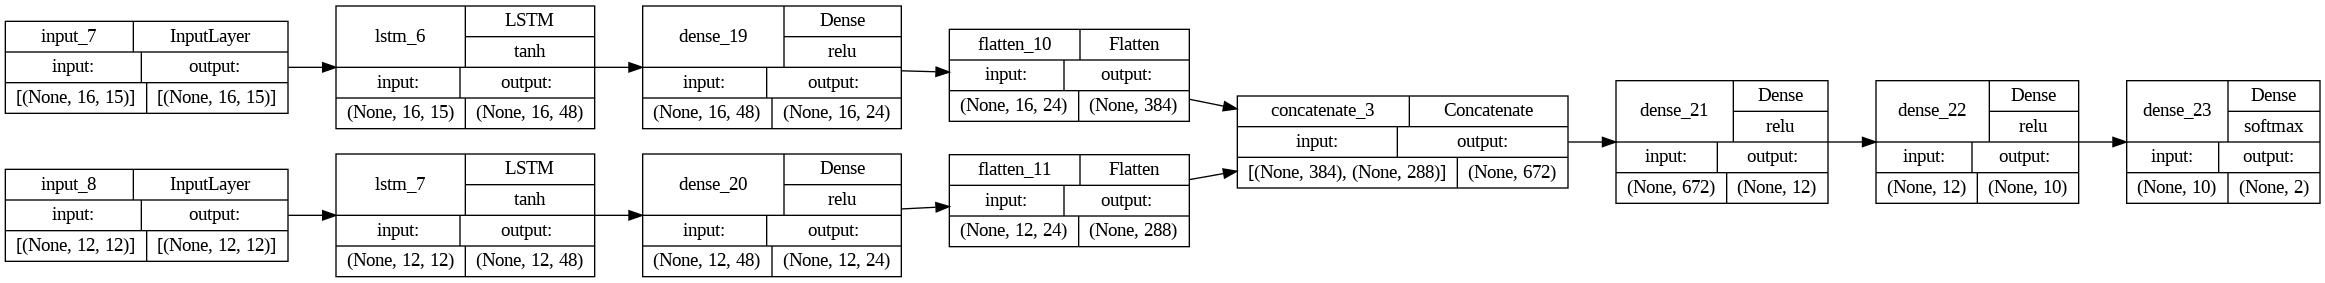

In [ ]:
# define input shapes for each feature
input_shape1 = (x_train1.shape[1], x_train1.shape[2]) # beats
input_shape2 = (x_train2.shape[1], x_train2.shape[2]) # pitch class

# define layers for first input - beats
input1 = Input(shape=(input_shape1))
lstm1 = LSTM(units=48, dropout=0.1, return_sequences=True)(input1)
dense1 = Dense(units=24, activation='relu')(lstm1)
flat1 = Flatten()(dense1)

# define layers for second input - pitch class
input2 = Input(shape=(input_shape2))
lstm2 = LSTM(units=48, dropout=0.1, return_sequences=True)(input2)
dense2 = Dense(units=24, activation='relu')(lstm2)
flat2 = Flatten()(dense2)

# concatenate inputs/layers together
inputs_concat = Concatenate(axis=1)([flat1, flat2])

# build remainder layers to output
dense3 = Dense(12, activation='relu')(inputs_concat)
dense4 = Dense(10, activation='relu')(dense3)
output = Dense(2, activation='softmax')(dense4)

# construct model
model_bach_lstm = Model(inputs=[input1, input2], outputs=output)

# bach lstm - compile the model
model_bach_lstm.compile(
              optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy', # sparse categorical crossentropy loss function
              metrics=['accuracy'])

# early stopping callback if learning stalls
callback = EarlyStopping(monitor='loss', patience=3)

# bach lstm - train the model
model_bach_lstm.fit((x_train1, x_train2), y_train, batch_size=32, epochs=25, callbacks=[callback], validation_data=((x_val1, x_val2), y_val))

# bach lstm - evaluate the model on the test set
test_loss, test_acc = model_bach_lstm.evaluate((x_test1, x_test2), y_test)
print('\nTest accuracy:', "{:.4%}".format(test_acc), '\n')

# plot model visualization
plot_model(model_bach_lstm, to_file='model_bach_lstm.png', show_shapes=True, rankdir='LR', show_layer_activations=True)

### Evaluate

8/8 [==============================] - 2s 236ms/step
Bach - LSTM 

Train Accuracy: 84.52%
Test Accuracy: 75.00%
Precision: 66.67%
Recall: 100.00%
F1 Score: 80.00%


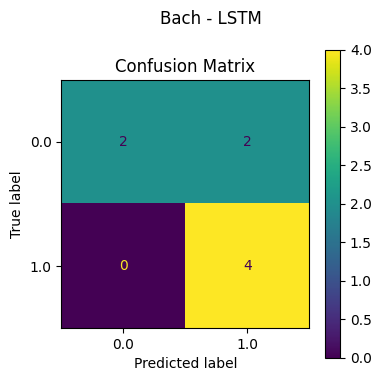

In [ ]:
# bach lstm - call function to build confusion matrix
bach_lstm_score_accuracy_train, bach_lstm_score_accuracy_test, bach_lstm_score_precision, bach_lstm_score_recall, bach_lstm_score_f1 = build_confusion_matrix(
    model=model_bach_lstm, description='Bach - LSTM', x_train=(x_train1, x_train2), x_test=(x_test1, x_test2), y_train=y_train, y_test=y_test)

## Chopin - CNN (Kobe)

### Split Datasets

In [ ]:
# call function to build and split datasets
x_train, y_train, x_val, y_val, x_test, y_test = build_datasets_cnn(composer_name = 'chopin',
                                                                    composer_train = chopin_train,
                                                                    composer_val = chopin_dev,
                                                                    composer_test = chopin_test,
                                                                    feature_to_extract = 'chroma',
                                                                    feature_length = 2000)

# print input shape to go into cnn model
print('\nInput Shape for Training:')
print('x_train:', x_train.shape)

Begin processing TRAIN dataset:
Processing file 5 of 82.
Processing file 10 of 82.
Processing file 15 of 82.
Processing file 20 of 82.
Processing file 25 of 82.
Processing file 30 of 82.
Processing file 35 of 82.
Processing file 40 of 82.
Processing file 45 of 82.
Processing file 50 of 82.
Processing file 55 of 82.
Processing file 60 of 82.
Processing file 65 of 82.
Processing file 70 of 82.
Processing file 75 of 82.
Processing file 80 of 82.

Begin processing VAL dataset:
Processing file 5 of 8.

Begin processing TEST dataset:
Processing file 5 of 8.

Input Shape for Training:
x_train: (82, 12, 2000, 1)


### Build, Train, and Optimize

Epoch 1/25
3/3 [==============================] - 1s 353ms/step - loss: 0.8568 - accuracy: 0.5000 - val_loss: 1.7342 - val_accuracy: 0.5000
Epoch 2/25
3/3 [==============================] - 2s 893ms/step - loss: 0.7085 - accuracy: 0.6341 - val_loss: 1.2534 - val_accuracy: 0.5000
Epoch 3/25
3/3 [==============================] - 1s 200ms/step - loss: 0.3979 - accuracy: 0.9146 - val_loss: 1.1368 - val_accuracy: 0.3750
Epoch 4/25
3/3 [==============================] - 2s 923ms/step - loss: 0.3560 - accuracy: 0.9024 - val_loss: 1.4725 - val_accuracy: 0.3750
Epoch 5/25
3/3 [==============================] - 1s 191ms/step - loss: 0.2727 - accuracy: 0.9756 - val_loss: 1.8433 - val_accuracy: 0.3750
Epoch 6/25
3/3 [==============================] - 1s 343ms/step - loss: 0.2345 - accuracy: 0.9634 - val_loss: 1.9574 - val_accuracy: 0.3750
Epoch 7/25
3/3 [==============================] - 2s 897ms/step - loss: 0.1935 - accuracy: 0.9756 - val_loss: 1.8690 - val_accuracy: 0.3750
Epoch 8/25
3/3 [====

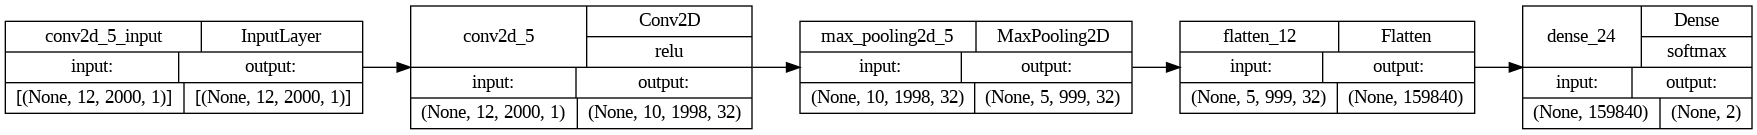

In [ ]:
# define input shape
input_shape = (x_train.shape[1], x_train.shape[2], x_train.shape[3])

# chopin cnn - define the cnn model
model_chopin_cnn = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(2, activation='softmax') # 2 units for binary classification using softmax
])

# chopin cnn - compile the model
model_chopin_cnn.compile(optimizer=Adam(learning_rate=0.001),
                         loss='sparse_categorical_crossentropy', # sparse categorical crossentropy loss function
                         metrics=['accuracy'])

# early stopping callback if learning stalls
callback = EarlyStopping(monitor='loss', patience=3)

# chopin cnn - train the model
model_chopin_cnn.fit(x_train, y_train, batch_size=32, epochs=25, callbacks=[callback], validation_data=(x_val, y_val))

# chopin cnn - evaluate the model on the test set
test_loss, test_acc = model_chopin_cnn.evaluate(x_test, y_test)
print('\nTest accuracy:', "{:.4%}".format(test_acc), '\n')

# plot model visualization
plot_model(model_chopin_cnn, to_file='model_chopin_cnn.png', show_shapes=True, rankdir='LR', show_layer_activations=True)

### Evaluate

8/8 [==============================] - 0s 6ms/step
Chopin - CNN 

Train Accuracy: 100.00%
Test Accuracy: 87.50%
Precision: 80.00%
Recall: 100.00%
F1 Score: 88.89%


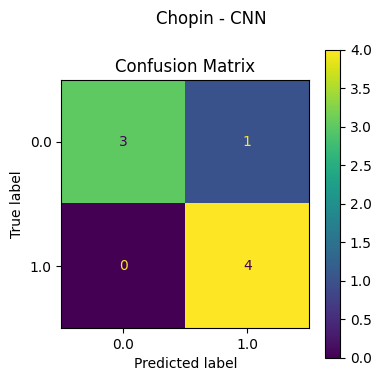

In [ ]:
# chopin cnn - call function to build confusion matrix
chopin_cnn_score_accuracy_train, chopin_cnn_score_accuracy_test, chopin_cnn_score_precision, chopin_cnn_score_recall, chopin_cnn_score_f1 = build_confusion_matrix(
    model=model_chopin_cnn, description='Chopin - CNN', x_train=x_train, x_test=x_test, y_train=y_train, y_test=y_test)

### Optimize

#### Split Datasets

In [ ]:
# call function to build and split datasets
x_train, y_train, x_val, y_val, x_test, y_test = build_datasets_cnn(composer_name = 'chopin',
                                                                    composer_train = chopin_train,
                                                                    composer_val = chopin_dev,
                                                                    composer_test = chopin_test,
                                                                    feature_to_extract = 'chroma',
                                                                    feature_length = 1000)

# print input shape to go into cnn model
print('\nInput Shape for Training:')
print('x_train:', x_train.shape)

Begin processing TRAIN dataset:
Processing file 5 of 82.
Processing file 10 of 82.
Processing file 15 of 82.
Processing file 20 of 82.
Processing file 25 of 82.
Processing file 30 of 82.
Processing file 35 of 82.
Processing file 40 of 82.
Processing file 45 of 82.
Processing file 50 of 82.
Processing file 55 of 82.
Processing file 60 of 82.
Processing file 65 of 82.
Processing file 70 of 82.
Processing file 75 of 82.
Processing file 80 of 82.

Begin processing VAL dataset:
Processing file 5 of 8.

Begin processing TEST dataset:
Processing file 5 of 8.

Input Shape for Training:
x_train: (82, 12, 1000, 1)


#### Build, Train, and Optimize

Epoch 1/25
3/3 [==============================] - 1s 246ms/step - loss: 1.0318 - accuracy: 0.6707 - val_loss: 0.6741 - val_accuracy: 0.5000
Epoch 2/25
3/3 [==============================] - 1s 167ms/step - loss: 0.4322 - accuracy: 0.8171 - val_loss: 0.6451 - val_accuracy: 0.8750
Epoch 3/25
3/3 [==============================] - 1s 168ms/step - loss: 0.3732 - accuracy: 0.8780 - val_loss: 0.6383 - val_accuracy: 0.8750
Epoch 4/25
3/3 [==============================] - 1s 206ms/step - loss: 0.0831 - accuracy: 0.9756 - val_loss: 0.6191 - val_accuracy: 0.8750
Epoch 5/25
3/3 [==============================] - 1s 310ms/step - loss: 0.0858 - accuracy: 0.9634 - val_loss: 0.6147 - val_accuracy: 0.8750
Epoch 6/25
3/3 [==============================] - 1s 297ms/step - loss: 0.0381 - accuracy: 0.9878 - val_loss: 0.6188 - val_accuracy: 0.8750
Epoch 7/25
3/3 [==============================] - 1s 284ms/step - loss: 0.0614 - accuracy: 0.9756 - val_loss: 0.6161 - val_accuracy: 0.8750
Epoch 8/25
3/3 [====

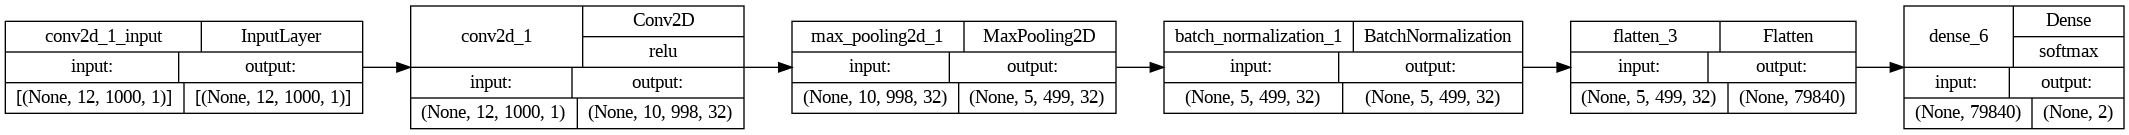

In [ ]:
# define input shape
input_shape = (x_train.shape[1], x_train.shape[2], x_train.shape[3])

# chopin cnn - define the cnn model
model_chopin_cnn = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
    MaxPooling2D((2,2)),
    tf.keras.layers.BatchNormalization(),
    Flatten(),
    Dense(2, activation='softmax') # 2 units for binary classification using softmax
])

# chopin cnn - compile the model
model_chopin_cnn.compile(optimizer=Adam(learning_rate=0.001),
                         loss='sparse_categorical_crossentropy', # sparse categorical crossentropy loss function
                         metrics=['accuracy'])

# early stopping callback if learning stalls
callback = EarlyStopping(monitor='loss', patience=3)

# chopin cnn - train the model
model_chopin_cnn.fit(x_train, y_train, batch_size=32, epochs=25, callbacks=[callback], validation_data=(x_val, y_val))

# chopin cnn - evaluate the model on the test set
test_loss, test_acc = model_chopin_cnn.evaluate(x_test, y_test)
print('\nTest accuracy:', "{:.4%}".format(test_acc), '\n')

# plot model visualization
plot_model(model_chopin_cnn, to_file='model_chopin_cnn.png', show_shapes=True, rankdir='LR', show_layer_activations=True)

#### Evaluate

8/8 [==============================] - 0s 5ms/step
Chopin - CNN 

Train Accuracy: 100.00%
Test Accuracy: 62.50%
Precision: 66.67%
Recall: 50.00%
F1 Score: 57.14%


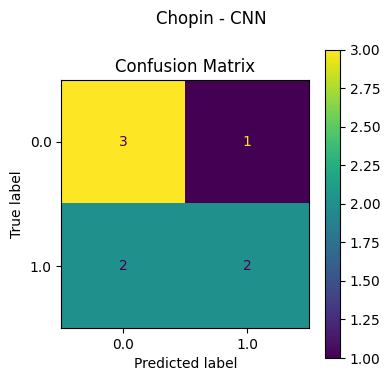

In [ ]:
# chopin cnn - call function to build confusion matrix
chopin_cnn_score_accuracy_train, chopin_cnn_score_accuracy_test, chopin_cnn_score_precision, chopin_cnn_score_recall, chopin_cnn_score_f1 = build_confusion_matrix(
    model=model_chopin_cnn, description='Chopin - CNN', x_train=x_train, x_test=x_test, y_train=y_train, y_test=y_test)

## Chopin - LSTM (Kobe)

### Split Datasets

In [ ]:
# call function to build and split datasets
x_train1, x_train2, y_train, x_val1, x_val2, y_val, x_test1, x_test2, y_test = build_datasets_lstm(composer_name = 'chopin',
                                                                                                   composer_train = chopin_train,
                                                                                                   composer_val = chopin_dev,
                                                                                                   composer_test = chopin_test,
                                                                                                   num_sequences_beats = 16,
                                                                                                   num_sequences_pitch_class = 12,
                                                                                                   window_size_beats=15,
                                                                                                   window_size_pitch_class=12)

# print input shape to go into lstm model
print('\nInput Shapes for Training:')
print('x_train1:', x_train1.shape)
print('x_train2:', x_train2.shape)

Begin processing TRAIN dataset:
Processing file 5 of 82.
Processing file 10 of 82.
Processing file 15 of 82.
Processing file 20 of 82.
Processing file 25 of 82.
Processing file 30 of 82.
Processing file 35 of 82.
Processing file 40 of 82.
Processing file 45 of 82.
Processing file 50 of 82.
Processing file 55 of 82.
Processing file 60 of 82.
Processing file 65 of 82.
Processing file 70 of 82.
Processing file 75 of 82.
Processing file 80 of 82.

Begin processing VAL dataset:
Processing file 5 of 8.

Begin processing TEST dataset:
Processing file 5 of 8.

Input Shapes for Training:
x_train1: (82, 16, 15, 1)
x_train2: (82, 12, 12, 1)


### Build, Train, and Optimize

Epoch 1/25
3/3 [==============================] - 4s 682ms/step - loss: 0.6943 - accuracy: 0.5000 - val_loss: 0.6907 - val_accuracy: 0.5000
Epoch 2/25
3/3 [==============================] - 0s 22ms/step - loss: 0.6927 - accuracy: 0.5000 - val_loss: 0.6903 - val_accuracy: 0.5000
Epoch 3/25
3/3 [==============================] - 0s 23ms/step - loss: 0.6919 - accuracy: 0.5000 - val_loss: 0.6905 - val_accuracy: 0.5000
Epoch 4/25
3/3 [==============================] - 0s 30ms/step - loss: 0.6912 - accuracy: 0.5000 - val_loss: 0.6904 - val_accuracy: 0.5000
Epoch 5/25
3/3 [==============================] - 0s 22ms/step - loss: 0.6906 - accuracy: 0.5000 - val_loss: 0.6903 - val_accuracy: 0.5000
Epoch 6/25
3/3 [==============================] - 0s 22ms/step - loss: 0.6910 - accuracy: 0.5000 - val_loss: 0.6900 - val_accuracy: 0.5000
Epoch 7/25
3/3 [==============================] - 0s 22ms/step - loss: 0.6899 - accuracy: 0.5000 - val_loss: 0.6896 - val_accuracy: 0.5000
Epoch 8/25
3/3 [==========

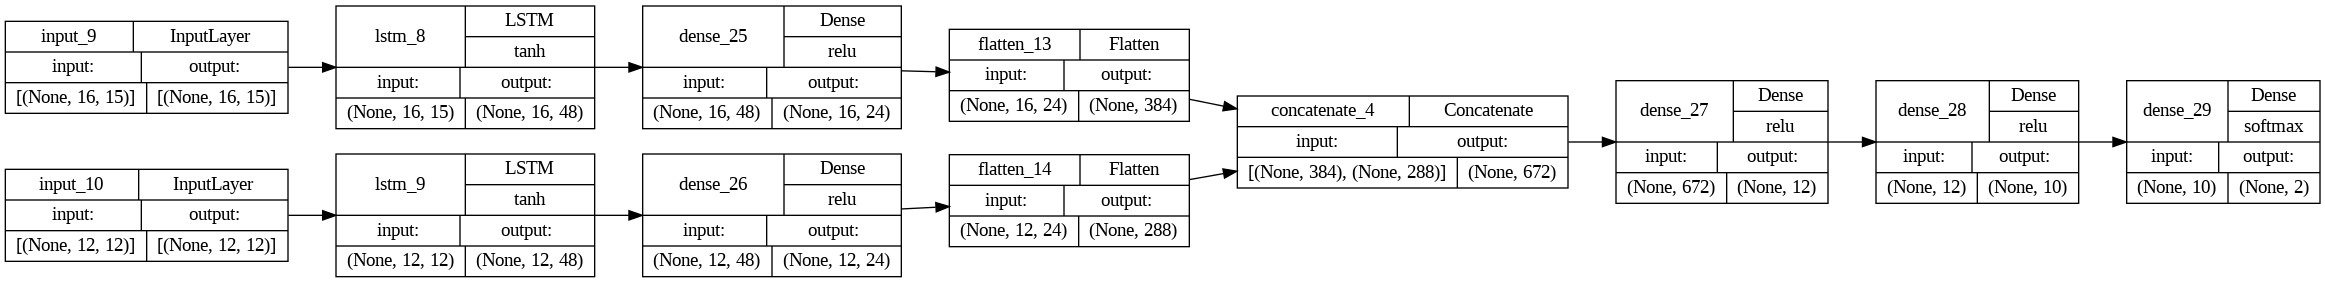

In [ ]:
# define input shapes for each feature
input_shape1 = (x_train1.shape[1], x_train1.shape[2]) # beats
input_shape2 = (x_train2.shape[1], x_train2.shape[2]) # pitch class

# define layers for first input - beats
input1 = Input(shape=(input_shape1))
lstm1 = LSTM(units=48, dropout=0.1, return_sequences=True)(input1)
dense1 = Dense(units=24, activation='relu')(lstm1)
flat1 = Flatten()(dense1)

# define layers for second input - pitch class
input2 = Input(shape=(input_shape2))
lstm2 = LSTM(units=48, dropout=0.1, return_sequences=True)(input2)
dense2 = Dense(units=24, activation='relu')(lstm2)
flat2 = Flatten()(dense2)

# concatenate inputs/layers together
inputs_concat = Concatenate(axis=1)([flat1, flat2])

# build remainder layers to output
dense3 = Dense(12, activation='relu')(inputs_concat)
dense4 = Dense(10, activation='relu')(dense3)
output = Dense(2, activation='softmax')(dense4)

# construct model
model_chopin_lstm = Model(inputs=[input1, input2], outputs=output)

# chopin lstm - compile the model
model_chopin_lstm.compile(
              optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy', # sparse categorical crossentropy loss function
              metrics=['accuracy'])

# early stopping callback if learning stalls
callback = EarlyStopping(monitor='loss', patience=3)

# chopin lstm - train the model
model_chopin_lstm.fit((x_train1, x_train2), y_train, batch_size=32, epochs=25, callbacks=[callback], validation_data=((x_val1, x_val2), y_val))

# chopin lstm - evaluate the model on the test set
test_loss, test_acc = model_chopin_lstm.evaluate((x_test1, x_test2), y_test)
print('\nTest accuracy:', "{:.4%}".format(test_acc), '\n')

# plot model visualization
plot_model(model_chopin_lstm, to_file='model_chopin_lstm.png', show_shapes=True, rankdir='LR', show_layer_activations=True)

### Evaluate

8/8 [==============================] - 2s 250ms/step
Chopin - LSTM 

Train Accuracy: 65.85%
Test Accuracy: 62.50%
Precision: 100.00%
Recall: 25.00%
F1 Score: 40.00%


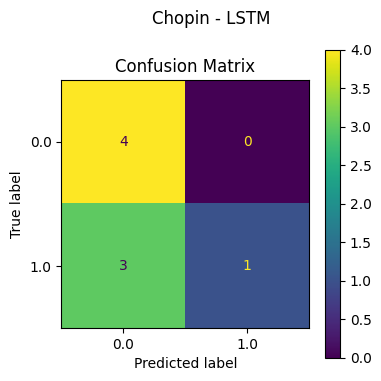

In [ ]:
# chopin lstm - call function to build confusion matrix
chopin_lstm_score_accuracy_train, chopin_lstm_score_accuracy_test, chopin_lstm_score_precision, chopin_lstm_score_recall, chopin_lstm_score_f1 = build_confusion_matrix(
    model=model_chopin_lstm, description='Chopin - LSTM', x_train=(x_train1, x_train2), x_test=(x_test1, x_test2), y_train=y_train, y_test=y_test)

## Byrd - CNN (Kobe)

### Split Datasets

In [ ]:
# call function to build and split datasets
x_train, y_train, x_val, y_val, x_test, y_test = build_datasets_cnn(composer_name = 'byrd',
                                                                    composer_train = byrd_train,
                                                                    composer_val = byrd_dev,
                                                                    composer_test = byrd_test,
                                                                    feature_to_extract = 'chroma',
                                                                    feature_length = 2000)

# print input shape to go into cnn model
print('\nInput Shape for Training:')
print('x_train:', x_train.shape)

Begin processing TRAIN dataset:
Processing file 5 of 84.
Processing file 10 of 84.
Processing file 15 of 84.
Processing file 20 of 84.
Processing file 25 of 84.
Processing file 30 of 84.
Processing file 35 of 84.
Processing file 40 of 84.
Processing file 45 of 84.
Processing file 50 of 84.
Processing file 55 of 84.
Processing file 60 of 84.
Processing file 65 of 84.
Processing file 70 of 84.
Processing file 75 of 84.
Processing file 80 of 84.

Begin processing VAL dataset:
Processing file 5 of 8.

Begin processing TEST dataset:
Processing file 5 of 8.

Input Shape for Training:
x_train: (84, 12, 2000, 1)


### Build, Train, and Optimize

Epoch 1/25
3/3 [==============================] - 1s 372ms/step - loss: 1.0850 - accuracy: 0.4881 - val_loss: 0.6173 - val_accuracy: 0.7500
Epoch 2/25
3/3 [==============================] - 3s 2s/step - loss: 0.5273 - accuracy: 0.7500 - val_loss: 0.5389 - val_accuracy: 0.7500
Epoch 3/25
3/3 [==============================] - 1s 208ms/step - loss: 0.3229 - accuracy: 0.9524 - val_loss: 0.4779 - val_accuracy: 0.7500
Epoch 4/25
3/3 [==============================] - 1s 622ms/step - loss: 0.2831 - accuracy: 0.8810 - val_loss: 0.4242 - val_accuracy: 0.6250
Epoch 5/25
3/3 [==============================] - 1s 203ms/step - loss: 0.1833 - accuracy: 0.9524 - val_loss: 0.5163 - val_accuracy: 0.7500
Epoch 6/25
3/3 [==============================] - 1s 208ms/step - loss: 0.1614 - accuracy: 0.9524 - val_loss: 0.4653 - val_accuracy: 0.7500
Epoch 7/25
3/3 [==============================] - 2s 676ms/step - loss: 0.1062 - accuracy: 0.9881 - val_loss: 0.4266 - val_accuracy: 0.6250
Epoch 8/25
3/3 [=======

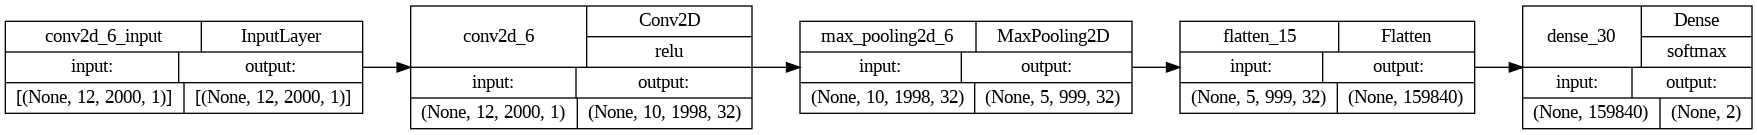

In [ ]:
# define input shape
input_shape = (x_train.shape[1], x_train.shape[2], x_train.shape[3])

# byrd cnn - define the cnn model
model_byrd_cnn = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(2, activation='softmax') # 2 units for binary classification using softmax
])

# byrd cnn - compile the model
model_byrd_cnn.compile(optimizer=Adam(learning_rate=0.001),
                         loss='sparse_categorical_crossentropy', # sparse categorical crossentropy loss function
                         metrics=['accuracy'])

# early stopping callback if learning stalls
callback = EarlyStopping(monitor='loss', patience=3)

# byrd cnn - train the model
model_byrd_cnn.fit(x_train, y_train, batch_size=32, epochs=25, callbacks=[callback], validation_data=(x_val, y_val))

# byrd cnn - evaluate the model on the test set
test_loss, test_acc = model_byrd_cnn.evaluate(x_test, y_test)
print('\nTest accuracy:', "{:.4%}".format(test_acc), '\n')

# plot model visualization
plot_model(model_byrd_cnn, to_file='model_byrd_cnn.png', show_shapes=True, rankdir='LR', show_layer_activations=True)

### Evaluate

8/8 [==============================] - 0s 4ms/step
Byrd - CNN 

Train Accuracy: 100.00%
Test Accuracy: 100.00%
Precision: 100.00%
Recall: 100.00%
F1 Score: 100.00%


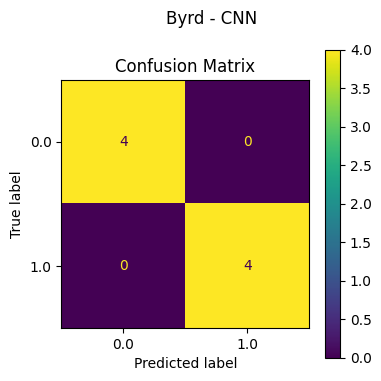

In [ ]:
# byrd cnn - call function to build confusion matrix
byrd_cnn_score_accuracy_train, byrd_cnn_score_accuracy_test, byrd_cnn_score_precision, byrd_cnn_score_recall, byrd_cnn_score_f1 = build_confusion_matrix(
    model=model_byrd_cnn, description='Byrd - CNN', x_train=x_train, x_test=x_test, y_train=y_train, y_test=y_test)

### Optimize

#### Split Datasets

In [ ]:
# call function to build and split datasets
x_train, y_train, x_val, y_val, x_test, y_test = build_datasets_cnn(composer_name = 'byrd',
                                                                    composer_train = byrd_train,
                                                                    composer_val = byrd_dev,
                                                                    composer_test = byrd_test,
                                                                    feature_to_extract = 'chroma',
                                                                    feature_length = 1000)

# print input shape to go into cnn model
print('\nInput Shape for Training:')
print('x_train:', x_train.shape)

Begin processing TRAIN dataset:
Processing file 5 of 84.
Processing file 10 of 84.
Processing file 15 of 84.
Processing file 20 of 84.
Processing file 25 of 84.
Processing file 30 of 84.
Processing file 35 of 84.
Processing file 40 of 84.
Processing file 45 of 84.
Processing file 50 of 84.
Processing file 55 of 84.
Processing file 60 of 84.
Processing file 65 of 84.
Processing file 70 of 84.
Processing file 75 of 84.
Processing file 80 of 84.

Begin processing VAL dataset:
Processing file 5 of 8.

Begin processing TEST dataset:
Processing file 5 of 8.

Input Shape for Training:
x_train: (84, 12, 1000, 1)


#### Build, Train, and Optimize

Epoch 1/25
3/3 [==============================] - 3s 407ms/step - loss: 1.4910 - accuracy: 0.7500 - val_loss: 0.8887 - val_accuracy: 0.5000
Epoch 2/25
3/3 [==============================] - 1s 308ms/step - loss: 3.2191 - accuracy: 0.8690 - val_loss: 0.7851 - val_accuracy: 0.5000
Epoch 3/25
3/3 [==============================] - 1s 255ms/step - loss: 1.5605 - accuracy: 0.9167 - val_loss: 0.6084 - val_accuracy: 0.5000
Epoch 4/25
3/3 [==============================] - 1s 209ms/step - loss: 0.4034 - accuracy: 0.9524 - val_loss: 0.5497 - val_accuracy: 0.7500
Epoch 5/25
3/3 [==============================] - 1s 178ms/step - loss: 0.0087 - accuracy: 0.9881 - val_loss: 0.5357 - val_accuracy: 0.7500
Epoch 6/25
3/3 [==============================] - 1s 190ms/step - loss: 2.0115e-04 - accuracy: 1.0000 - val_loss: 0.5280 - val_accuracy: 0.7500
Epoch 7/25
3/3 [==============================] - 1s 306ms/step - loss: 1.4644e-04 - accuracy: 1.0000 - val_loss: 0.5230 - val_accuracy: 0.7500
Epoch 8/25
3

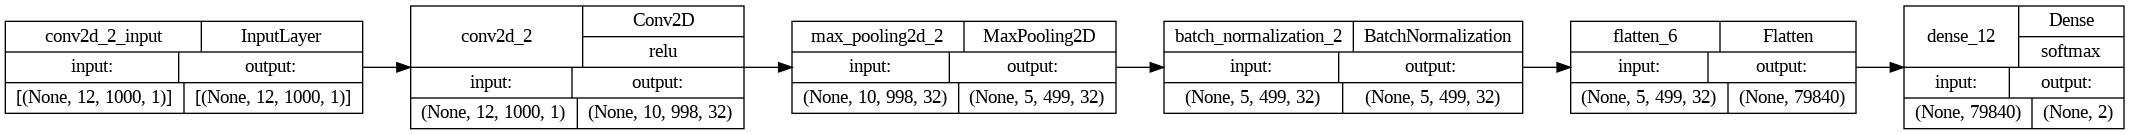

In [ ]:
# define input shape
input_shape = (x_train.shape[1], x_train.shape[2], x_train.shape[3])

# byrd cnn - define the cnn model
model_byrd_cnn = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
    MaxPooling2D((2,2)),
    tf.keras.layers.BatchNormalization(),
    Flatten(),
    Dense(2, activation='softmax') # 2 units for binary classification using softmax
])

# byrd cnn - compile the model
model_byrd_cnn.compile(optimizer=Adam(learning_rate=0.001),
                         loss='sparse_categorical_crossentropy', # sparse categorical crossentropy loss function
                         metrics=['accuracy'])

# early stopping callback if learning stalls
callback = EarlyStopping(monitor='loss', patience=3)

# byrd cnn - train the model
model_byrd_cnn.fit(x_train, y_train, batch_size=32, epochs=25, callbacks=[callback], validation_data=(x_val, y_val))

# byrd cnn - evaluate the model on the test set
test_loss, test_acc = model_byrd_cnn.evaluate(x_test, y_test)
print('\nTest accuracy:', "{:.4%}".format(test_acc), '\n')

# plot model visualization
plot_model(model_byrd_cnn, to_file='model_byrd_cnn.png', show_shapes=True, rankdir='LR', show_layer_activations=True)

#### Evaluate

8/8 [==============================] - 0s 4ms/step
Byrd - CNN 

Train Accuracy: 92.86%
Test Accuracy: 75.00%
Precision: 75.00%
Recall: 75.00%
F1 Score: 75.00%


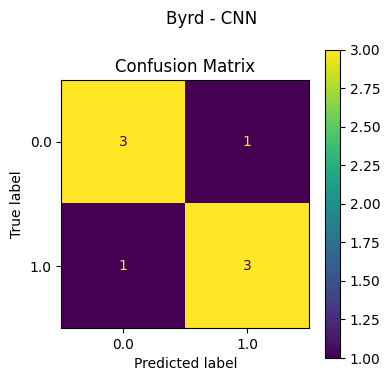

In [ ]:
# byrd cnn - call function to build confusion matrix
byrd_cnn_score_accuracy_train, byrd_cnn_score_accuracy_test, byrd_cnn_score_precision, byrd_cnn_score_recall, byrd_cnn_score_f1 = build_confusion_matrix(
    model=model_byrd_cnn, description='Byrd - CNN', x_train=x_train, x_test=x_test, y_train=y_train, y_test=y_test)

## Byrd - LSTM (Kobe)

### Split Datasets

In [ ]:
# call function to build and split datasets
x_train1, x_train2, y_train, x_val1, x_val2, y_val, x_test1, x_test2, y_test = build_datasets_lstm(composer_name = 'byrd',
                                                                                                   composer_train = byrd_train,
                                                                                                   composer_val = byrd_dev,
                                                                                                   composer_test = byrd_test,
                                                                                                   num_sequences_beats = 16,
                                                                                                   num_sequences_pitch_class = 12,
                                                                                                   window_size_beats=15,
                                                                                                   window_size_pitch_class=12)

# print input shape to go into lstm model
print('\nInput Shapes for Training:')
print('x_train1:', x_train1.shape)
print('x_train2:', x_train2.shape)

Begin processing TRAIN dataset:
Processing file 5 of 84.
Processing file 10 of 84.
Processing file 15 of 84.
Processing file 20 of 84.
Processing file 25 of 84.
Processing file 30 of 84.
Processing file 35 of 84.
Processing file 40 of 84.
Processing file 45 of 84.
Processing file 50 of 84.
Processing file 55 of 84.
Processing file 60 of 84.
Processing file 65 of 84.
Processing file 70 of 84.
Processing file 75 of 84.
Processing file 80 of 84.

Begin processing VAL dataset:
Processing file 5 of 8.

Begin processing TEST dataset:
Processing file 5 of 8.

Input Shapes for Training:
x_train1: (84, 16, 15, 1)
x_train2: (84, 12, 12, 1)


### Build, Train, and Optimize

Epoch 1/25
3/3 [==============================] - 4s 663ms/step - loss: 0.6935 - accuracy: 0.4524 - val_loss: 0.6905 - val_accuracy: 0.5000
Epoch 2/25
3/3 [==============================] - 0s 24ms/step - loss: 0.6877 - accuracy: 0.6429 - val_loss: 0.6872 - val_accuracy: 0.6250
Epoch 3/25
3/3 [==============================] - 0s 31ms/step - loss: 0.6783 - accuracy: 0.8452 - val_loss: 0.6802 - val_accuracy: 0.5000
Epoch 4/25
3/3 [==============================] - 0s 21ms/step - loss: 0.6655 - accuracy: 0.5238 - val_loss: 0.6718 - val_accuracy: 0.5000
Epoch 5/25
3/3 [==============================] - 0s 25ms/step - loss: 0.6504 - accuracy: 0.4881 - val_loss: 0.6606 - val_accuracy: 0.5000
Epoch 6/25
3/3 [==============================] - 0s 21ms/step - loss: 0.6323 - accuracy: 0.5238 - val_loss: 0.6459 - val_accuracy: 1.0000
Epoch 7/25
3/3 [==============================] - 0s 20ms/step - loss: 0.6066 - accuracy: 0.6548 - val_loss: 0.6266 - val_accuracy: 1.0000
Epoch 8/25
3/3 [==========

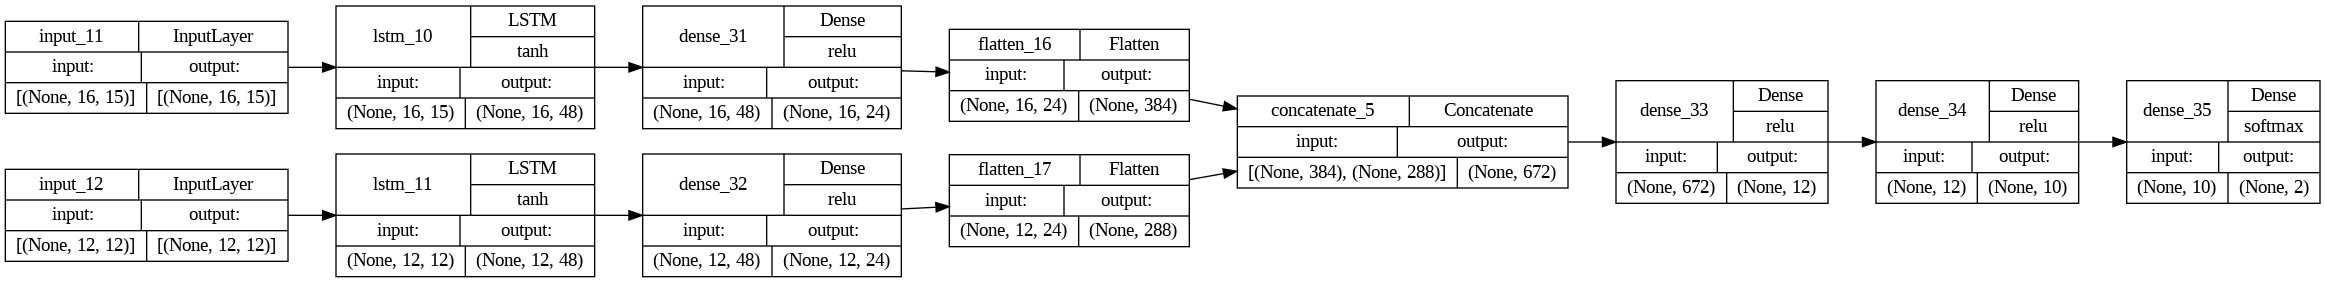

In [ ]:
# define input shapes for each feature
input_shape1 = (x_train1.shape[1], x_train1.shape[2]) # beats
input_shape2 = (x_train2.shape[1], x_train2.shape[2]) # pitch class

# define layers for first input - beats
input1 = Input(shape=(input_shape1))
lstm1 = LSTM(units=48, dropout=0.1, return_sequences=True)(input1)
dense1 = Dense(units=24, activation='relu')(lstm1)
flat1 = Flatten()(dense1)

# define layers for second input - pitch class
input2 = Input(shape=(input_shape2))
lstm2 = LSTM(units=48, dropout=0.1, return_sequences=True)(input2)
dense2 = Dense(units=24, activation='relu')(lstm2)
flat2 = Flatten()(dense2)

# concatenate inputs/layers together
inputs_concat = Concatenate(axis=1)([flat1, flat2])

# build remainder layers to output
dense3 = Dense(12, activation='relu')(inputs_concat)
dense4 = Dense(10, activation='relu')(dense3)
output = Dense(2, activation='softmax')(dense4)

# construct model
model_byrd_lstm = Model(inputs=[input1, input2], outputs=output)

# byrd lstm - compile the model
model_byrd_lstm.compile(
              optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy', # sparse categorical crossentropy loss function
              metrics=['accuracy'])

# early stopping callback if learning stalls
callback = EarlyStopping(monitor='loss', patience=3)

# byrd lstm - train the model
model_byrd_lstm.fit((x_train1, x_train2), y_train, batch_size=32, epochs=25, callbacks=[callback], validation_data=((x_val1, x_val2), y_val))

# byrd lstm - evaluate the model on the test set
test_loss, test_acc = model_byrd_lstm.evaluate((x_test1, x_test2), y_test)
print('\nTest accuracy:', "{:.4%}".format(test_acc), '\n')

# plot model visualization
plot_model(model_byrd_lstm, to_file='model_byrd_lstm.png', show_shapes=True, rankdir='LR', show_layer_activations=True)

### Evaluate

8/8 [==============================] - 0s 2ms/step
Byrd - LSTM 

Train Accuracy: 96.43%
Test Accuracy: 100.00%
Precision: 100.00%
Recall: 100.00%
F1 Score: 100.00%


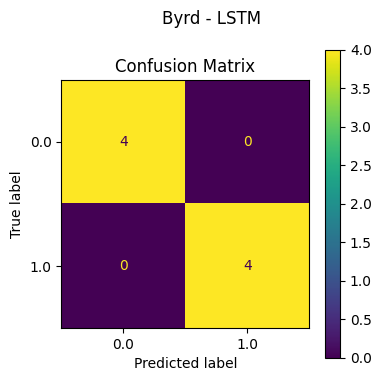

In [ ]:
# byrd lstm - call function to build confusion matrix
byrd_lstm_score_accuracy_train, byrd_lstm_score_accuracy_test, byrd_lstm_score_precision, byrd_lstm_score_recall, byrd_lstm_score_f1 = build_confusion_matrix(
    model=model_byrd_lstm, description='Byrd - LSTM', x_train=(x_train1, x_train2), x_test=(x_test1, x_test2), y_train=y_train, y_test=y_test)

## Bartok - CNN (Aria)

### Split Datasets

In [ ]:
# call function to build and split datasets
x_train, y_train, x_val, y_val, x_test, y_test = build_datasets_cnn(composer_name = 'bartok',
                                                                    composer_train = bartok_train,
                                                                    composer_val = bartok_dev,
                                                                    composer_test = bartok_test,
                                                                    feature_to_extract = 'chroma',
                                                                    feature_length = 2000)

# print input shape to go into cnn model
print('\nInput Shape for Training:')
print('x_train:', x_train.shape)

Begin processing TRAIN dataset:
Processing file 5 of 82.
Processing file 10 of 82.
Processing file 15 of 82.
Processing file 20 of 82.
Processing file 25 of 82.
Processing file 30 of 82.
Processing file 35 of 82.
Processing file 40 of 82.
Processing file 45 of 82.
Processing file 50 of 82.
Processing file 55 of 82.
Processing file 60 of 82.
Processing file 65 of 82.
Processing file 70 of 82.
Processing file 75 of 82.
Processing file 80 of 82.

Begin processing VAL dataset:
Processing file 5 of 8.

Begin processing TEST dataset:
Processing file 5 of 8.

Input Shape for Training:
x_train: (82, 12, 2000, 1)


### Build, Train, and Optimize

Epoch 1/25
3/3 [==============================] - 3s 1s/step - loss: 0.8521 - accuracy: 0.4878 - val_loss: 1.5862 - val_accuracy: 0.5000
Epoch 2/25
3/3 [==============================] - 1s 240ms/step - loss: 0.7131 - accuracy: 0.5244 - val_loss: 1.2614 - val_accuracy: 0.3750
Epoch 3/25
3/3 [==============================] - 1s 274ms/step - loss: 0.5149 - accuracy: 0.8537 - val_loss: 0.7157 - val_accuracy: 0.6250
Epoch 4/25
3/3 [==============================] - 1s 429ms/step - loss: 0.4689 - accuracy: 0.8415 - val_loss: 0.6275 - val_accuracy: 0.8750
Epoch 5/25
3/3 [==============================] - 2s 999ms/step - loss: 0.4262 - accuracy: 0.8780 - val_loss: 0.6575 - val_accuracy: 0.6250
Epoch 6/25
3/3 [==============================] - 1s 224ms/step - loss: 0.3677 - accuracy: 0.9146 - val_loss: 0.7208 - val_accuracy: 0.5000
Epoch 7/25
3/3 [==============================] - 1s 572ms/step - loss: 0.3213 - accuracy: 0.9146 - val_loss: 0.7944 - val_accuracy: 0.3750
Epoch 8/25
3/3 [=======

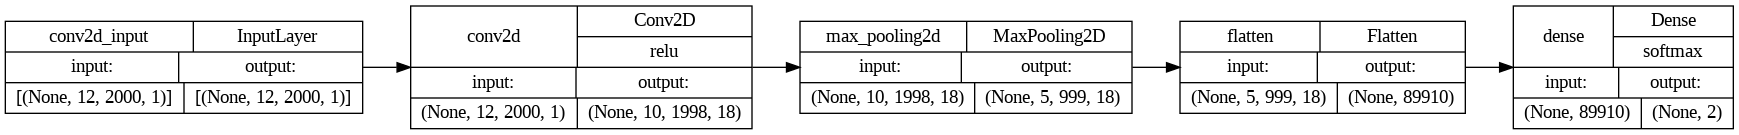

In [ ]:
# define input shape
input_shape = (x_train.shape[1], x_train.shape[2], x_train.shape[3])

# bartok cnn - define the cnn model
model_bartok_cnn = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
    MaxPooling2D((2,2)),
    #Dropout(.1),
    Flatten(),
    Dense(2, activation='softmax') # 2 units for binary classification using softmax
])

# bartok cnn - compile the model
model_bartok_cnn.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy', # sparse categorical crossentropy loss function
              metrics=['accuracy'])

# early stopping callback if learning stalls
callback = EarlyStopping(monitor='loss', patience=3)

# bartok cnn - train the model
model_bartok_cnn.fit(x_train, y_train, batch_size=32, epochs=25, callbacks=[callback], validation_data=(x_val, y_val))

# bartok cnn - evaluate the model on the test set
test_loss, test_acc = model_bartok_cnn.evaluate(x_test, y_test)
print('\nTest accuracy:', "{:.4%}".format(test_acc), '\n')

# plot model visualization
plot_model(model_mozart_cnn, to_file='model_schumann_cnn.png', show_shapes=True, rankdir='LR', show_layer_activations=True)

### Evaluate

8/8 [==============================] - 0s 6ms/step
Bartok - CNN 

Train Accuracy: 100.00%
Test Accuracy: 75.00%
Precision: 75.00%
Recall: 75.00%
F1 Score: 75.00%


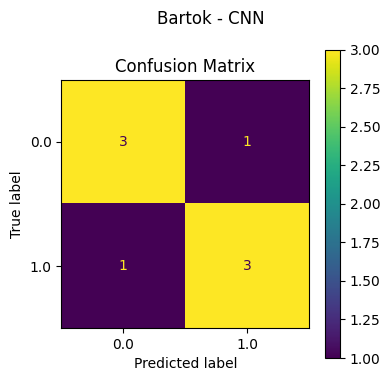

In [ ]:
# bartok cnn - call function to build confusion matrix
bartok_cnn_score_accuracy_train, bartok_cnn_score_accuracy_test, bartok_cnn_score_precision, bartok_cnn_score_recall, bartok_cnn_score_f1 = build_confusion_matrix(
    model=model_bartok_cnn, description='Bartok - CNN', x_train=x_train, x_test=x_test, y_train=y_train, y_test=y_test)

## Bartok - LSTM (Aria)

### Split Datasets

In [ ]:
# call function to build and split datasets
x_train1, x_train2, y_train, x_val1, x_val2, y_val, x_test1, x_test2, y_test = build_datasets_lstm(composer_name = 'bartok',
                                                                                                   composer_train = bartok_train,
                                                                                                   composer_val = bartok_dev,
                                                                                                   composer_test = bartok_test,
                                                                                                   num_sequences_beats = 16,
                                                                                                   num_sequences_pitch_class = 12,
                                                                                                   window_size_beats=15,
                                                                                                   window_size_pitch_class=12)

# print input shape to go into lstm model
print('\nInput Shapes for Training:')
print('x_train1:', x_train1.shape)
print('x_train2:', x_train2.shape)

Begin processing TRAIN dataset:
Processing file 5 of 82.
Processing file 10 of 82.
Processing file 15 of 82.
Processing file 20 of 82.
Processing file 25 of 82.
Processing file 30 of 82.
Processing file 35 of 82.
Processing file 40 of 82.
Processing file 45 of 82.
Processing file 50 of 82.
Processing file 55 of 82.
Processing file 60 of 82.
Processing file 65 of 82.
Processing file 70 of 82.
Processing file 75 of 82.
Processing file 80 of 82.

Begin processing VAL dataset:
Processing file 5 of 8.

Begin processing TEST dataset:
Processing file 5 of 8.

Input Shapes for Training:
x_train1: (82, 16, 15, 1)
x_train2: (82, 12, 12, 1)


### Build, Train, and Optimize

Epoch 1/25
3/3 [==============================] - 4s 705ms/step - loss: 0.6935 - accuracy: 0.4756 - val_loss: 0.6936 - val_accuracy: 0.3750
Epoch 2/25
3/3 [==============================] - 0s 30ms/step - loss: 0.6931 - accuracy: 0.4756 - val_loss: 0.6930 - val_accuracy: 0.5000
Epoch 3/25
3/3 [==============================] - 0s 40ms/step - loss: 0.6926 - accuracy: 0.5732 - val_loss: 0.6926 - val_accuracy: 0.6250
Epoch 4/25
3/3 [==============================] - 0s 30ms/step - loss: 0.6919 - accuracy: 0.6098 - val_loss: 0.6924 - val_accuracy: 0.6250
Epoch 5/25
3/3 [==============================] - 1s 24ms/step - loss: 0.6921 - accuracy: 0.5244 - val_loss: 0.6921 - val_accuracy: 0.6250
Epoch 6/25
3/3 [==============================] - 0s 25ms/step - loss: 0.6915 - accuracy: 0.6098 - val_loss: 0.6923 - val_accuracy: 0.5000
Epoch 7/25
3/3 [==============================] - 0s 28ms/step - loss: 0.6912 - accuracy: 0.5854 - val_loss: 0.6919 - val_accuracy: 0.5000
Epoch 8/25
3/3 [==========

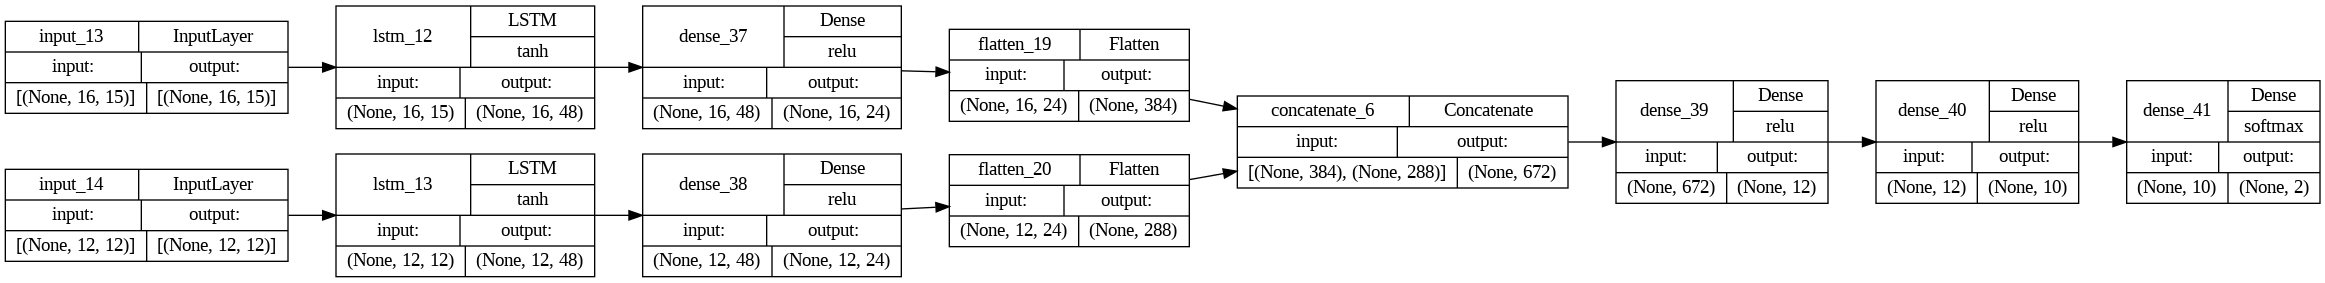

In [ ]:
# define input shapes for each feature
input_shape1 = (x_train1.shape[1], x_train1.shape[2]) # beats
input_shape2 = (x_train2.shape[1], x_train2.shape[2]) # pitch class

# define layers for first input - beats
input1 = Input(shape=(input_shape1))
lstm1 = LSTM(units=48, dropout=0.1, return_sequences=True)(input1)
dense1 = Dense(units=24, activation='relu')(lstm1)
flat1 = Flatten()(dense1)

# define layers for second input - pitch class
input2 = Input(shape=(input_shape2))
lstm2 = LSTM(units=48, dropout=0.1, return_sequences=True)(input2)
dense2 = Dense(units=24, activation='relu')(lstm2)
flat2 = Flatten()(dense2)

# concatenate inputs/layers together
inputs_concat = Concatenate(axis=1)([flat1, flat2])

# build remainder layers to output
dense3 = Dense(12, activation='relu')(inputs_concat)
dense4 = Dense(10, activation='relu')(dense3)
output = Dense(2, activation='softmax')(dense4)

# construct model
model_bartok_lstm = Model(inputs=[input1, input2], outputs=output)

# bartok lstm - compile the model
model_bartok_lstm.compile(
              optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy', # sparse categorical crossentropy loss function
              metrics=['accuracy'])

# early stopping callback if learning stalls
callback = EarlyStopping(monitor='loss', patience=3)

# bartok lstm - train the model
model_bartok_lstm.fit((x_train1, x_train2), y_train, batch_size=32, epochs=25, callbacks=[callback], validation_data=((x_val1, x_val2), y_val))

# bartok lstm - evaluate the model on the test set
test_loss, test_acc = model_bartok_lstm.evaluate((x_test1, x_test2), y_test)
print('\nTest accuracy:', "{:.4%}".format(test_acc), '\n')

# plot model visualization
plot_model(model_bartok_lstm, to_file='model_bartok_lstm.png', show_shapes=True, rankdir='LR', show_layer_activations=True)

### Evaluate

8/8 [==============================] - 0s 8ms/step
Bartok - LSTM 

Train Accuracy: 57.32%
Test Accuracy: 50.00%
Precision: 0.00%
Recall: 0.00%
F1 Score: 0.00%


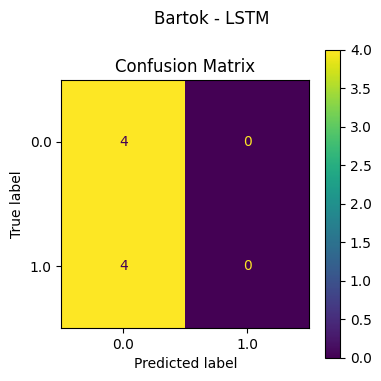

In [ ]:
# bartok lstm - call function to build confusion matrix
bartok_lstm_score_accuracy_train, bartok_lstm_score_accuracy_test, bartok_lstm_score_precision, bartok_lstm_score_recall, bartok_lstm_score_f1 = build_confusion_matrix(
    model=model_bartok_lstm, description='Bartok - LSTM', x_train=(x_train1, x_train2), x_test=(x_test1, x_test2), y_train=y_train, y_test=y_test)

## Handel - CNN (Aria)

### Split Datasets

In [ ]:
# call function to build and split datasets
x_train, y_train, x_val, y_val, x_test, y_test = build_datasets_cnn(composer_name = 'handel',
                                                                    composer_train = handel_train,
                                                                    composer_val = handel_dev,
                                                                    composer_test = handel_test,
                                                                    feature_to_extract = 'chroma',
                                                                    feature_length = 2000)

# print input shape to go into cnn model
print('\nInput Shape for Training:')
print('x_train:', x_train.shape)

Begin processing TRAIN dataset:
Processing file 5 of 82.
Processing file 10 of 82.
Processing file 15 of 82.
Processing file 20 of 82.
Processing file 25 of 82.
Processing file 30 of 82.
Processing file 35 of 82.
Processing file 40 of 82.
Processing file 45 of 82.
Processing file 50 of 82.
Processing file 55 of 82.
Processing file 60 of 82.
Processing file 65 of 82.
Processing file 70 of 82.
Processing file 75 of 82.
Processing file 80 of 82.

Begin processing VAL dataset:
Processing file 5 of 8.

Begin processing TEST dataset:
Processing file 5 of 8.

Input Shape for Training:
x_train: (82, 12, 2000, 1)


### Build, Train, and Optimize

Epoch 1/25
3/3 [==============================] - 1s 362ms/step - loss: 0.7126 - accuracy: 0.4878 - val_loss: 0.6077 - val_accuracy: 0.5000
Epoch 2/25
3/3 [==============================] - 1s 565ms/step - loss: 0.4979 - accuracy: 0.7073 - val_loss: 0.5427 - val_accuracy: 0.7500
Epoch 3/25
3/3 [==============================] - 1s 180ms/step - loss: 0.3787 - accuracy: 0.9146 - val_loss: 0.5181 - val_accuracy: 0.7500
Epoch 4/25
3/3 [==============================] - 3s 1s/step - loss: 0.3072 - accuracy: 0.9390 - val_loss: 0.5069 - val_accuracy: 0.8750
Epoch 5/25
3/3 [==============================] - 1s 204ms/step - loss: 0.2448 - accuracy: 0.9390 - val_loss: 0.4846 - val_accuracy: 0.7500
Epoch 6/25
3/3 [==============================] - 2s 1s/step - loss: 0.1900 - accuracy: 0.9756 - val_loss: 0.4769 - val_accuracy: 0.7500
Epoch 7/25
3/3 [==============================] - 1s 220ms/step - loss: 0.1473 - accuracy: 0.9756 - val_loss: 0.4774 - val_accuracy: 0.7500
Epoch 8/25
3/3 [==========

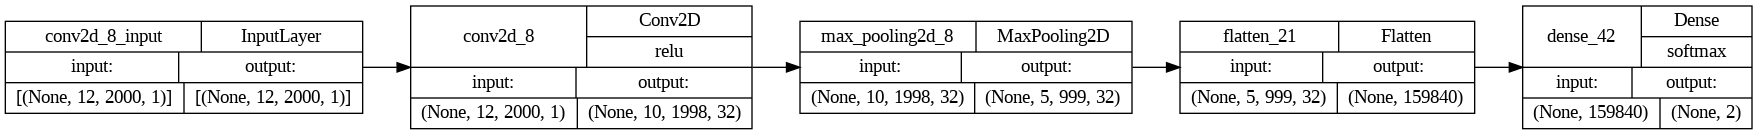

In [ ]:
# define input shape
input_shape = (x_train.shape[1], x_train.shape[2], x_train.shape[3])

# handel cnn - define the cnn model
model_handel_cnn = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(2, activation='softmax') # 2 units for binary classification using softmax
])

# handel cnn - compile the model
model_handel_cnn.compile(optimizer=Adam(learning_rate=0.001),
                         loss='sparse_categorical_crossentropy', # sparse categorical crossentropy loss function
                         metrics=['accuracy'])

# early stopping callback if learning stalls
callback = EarlyStopping(monitor='loss', patience=3)

# handel cnn - train the model
model_handel_cnn.fit(x_train, y_train, batch_size=32, epochs=25, callbacks=[callback], validation_data=(x_val, y_val))

# handel cnn - evaluate the model on the test set
test_loss, test_acc = model_handel_cnn.evaluate(x_test, y_test)
print('\nTest accuracy:', "{:.4%}".format(test_acc), '\n')

# plot model visualization
plot_model(model_handel_cnn, to_file='model_handel_cnn.png', show_shapes=True, rankdir='LR', show_layer_activations=True)

### Evaluate

8/8 [==============================] - 0s 4ms/step
Handel - CNN 

Train Accuracy: 100.00%
Test Accuracy: 75.00%
Precision: 75.00%
Recall: 75.00%
F1 Score: 75.00%


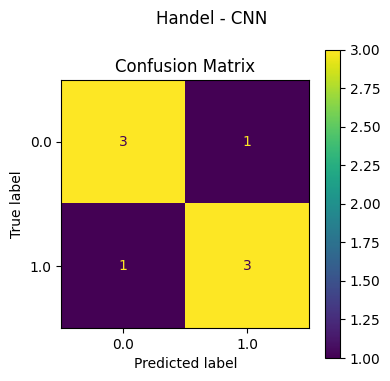

In [ ]:
# handel cnn - call function to build confusion matrix
handel_cnn_score_accuracy_train, handel_cnn_score_accuracy_test, handel_cnn_score_precision, handel_cnn_score_recall, handel_cnn_score_f1 = build_confusion_matrix(
    model=model_handel_cnn, description='Handel - CNN', x_train=x_train, x_test=x_test, y_train=y_train, y_test=y_test)

## Handel - LSTM (Aria)

### Split Datasets

In [ ]:
# call function to build and split datasets
x_train1, x_train2, y_train, x_val1, x_val2, y_val, x_test1, x_test2, y_test = build_datasets_lstm(composer_name = 'handel',
                                                                                                   composer_train = handel_train,
                                                                                                   composer_val = handel_dev,
                                                                                                   composer_test = handel_test,
                                                                                                   num_sequences_beats = 16,
                                                                                                   num_sequences_pitch_class = 12,
                                                                                                   window_size_beats=15,
                                                                                                   window_size_pitch_class=12)

# print input shape to go into lstm model
print('\nInput Shapes for Training:')
print('x_train1:', x_train1.shape)
print('x_train2:', x_train2.shape)

Begin processing TRAIN dataset:
Processing file 5 of 82.
Processing file 10 of 82.
Processing file 15 of 82.
Processing file 20 of 82.
Processing file 25 of 82.
Processing file 30 of 82.
Processing file 35 of 82.
Processing file 40 of 82.
Processing file 45 of 82.
Processing file 50 of 82.
Processing file 55 of 82.
Processing file 60 of 82.
Processing file 65 of 82.
Processing file 70 of 82.
Processing file 75 of 82.
Processing file 80 of 82.

Begin processing VAL dataset:
Processing file 5 of 8.

Begin processing TEST dataset:
Processing file 5 of 8.

Input Shapes for Training:
x_train1: (82, 16, 15, 1)
x_train2: (82, 12, 12, 1)


### Build, Train, and Optimize

Epoch 1/25
3/3 [==============================] - 4s 696ms/step - loss: 0.6934 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 2/25
3/3 [==============================] - 0s 37ms/step - loss: 0.6926 - accuracy: 0.5000 - val_loss: 0.6929 - val_accuracy: 0.5000
Epoch 3/25
3/3 [==============================] - 0s 45ms/step - loss: 0.6916 - accuracy: 0.5000 - val_loss: 0.6929 - val_accuracy: 0.5000
Epoch 4/25
3/3 [==============================] - 0s 31ms/step - loss: 0.6915 - accuracy: 0.5488 - val_loss: 0.6926 - val_accuracy: 0.6250
Epoch 5/25
3/3 [==============================] - 0s 30ms/step - loss: 0.6901 - accuracy: 0.6341 - val_loss: 0.6930 - val_accuracy: 0.5000
Epoch 6/25
3/3 [==============================] - 0s 33ms/step - loss: 0.6901 - accuracy: 0.5000 - val_loss: 0.6933 - val_accuracy: 0.5000
Epoch 7/25
3/3 [==============================] - 0s 38ms/step - loss: 0.6878 - accuracy: 0.5122 - val_loss: 0.6926 - val_accuracy: 0.3750
Epoch 8/25
3/3 [==========

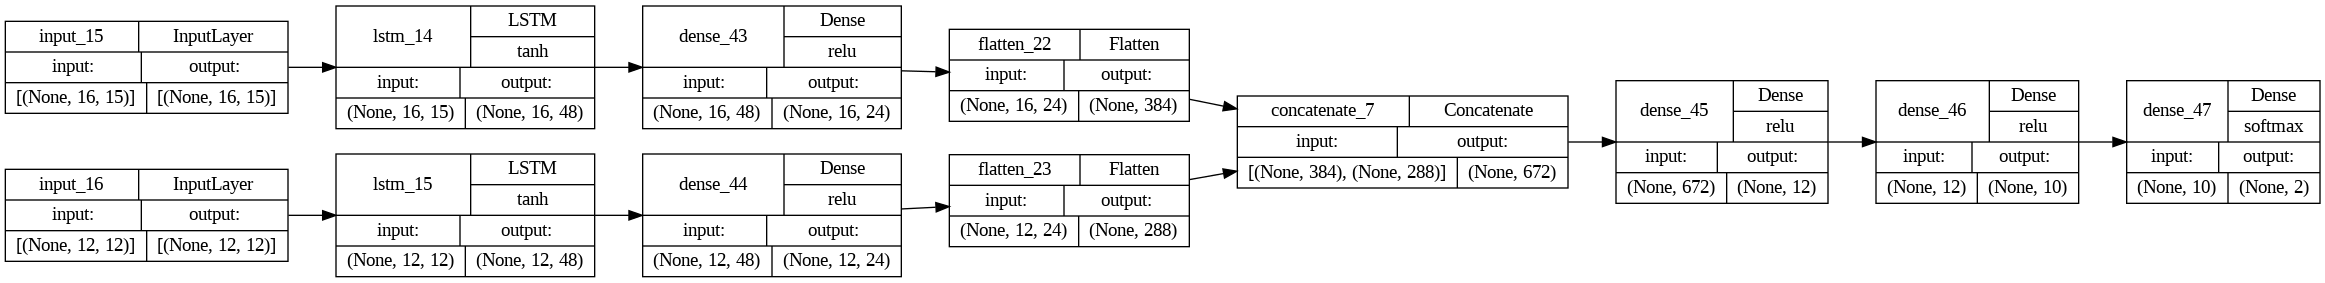

In [ ]:
# define input shapes for each feature
input_shape1 = (x_train1.shape[1], x_train1.shape[2]) # beats
input_shape2 = (x_train2.shape[1], x_train2.shape[2]) # pitch class

# define layers for first input - beats
input1 = Input(shape=(input_shape1))
lstm1 = LSTM(units=48, dropout=0.1, return_sequences=True)(input1)
dense1 = Dense(units=24, activation='relu')(lstm1)
flat1 = Flatten()(dense1)

# define layers for second input - pitch class
input2 = Input(shape=(input_shape2))
lstm2 = LSTM(units=48, dropout=0.1, return_sequences=True)(input2)
dense2 = Dense(units=24, activation='relu')(lstm2)
flat2 = Flatten()(dense2)

# concatenate inputs/layers together
inputs_concat = Concatenate(axis=1)([flat1, flat2])

# build remainder layers to output
dense3 = Dense(12, activation='relu')(inputs_concat)
dense4 = Dense(10, activation='relu')(dense3)
output = Dense(2, activation='softmax')(dense4)

# construct model
model_handel_lstm = Model(inputs=[input1, input2], outputs=output)

# handel lstm - compile the model
model_handel_lstm.compile(
              optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy', # sparse categorical crossentropy loss function
              metrics=['accuracy'])

# early stopping callback if learning stalls
callback = EarlyStopping(monitor='loss', patience=3)

# handel lstm - train the model
model_handel_lstm.fit((x_train1, x_train2), y_train, batch_size=32, epochs=25, callbacks=[callback], validation_data=((x_val1, x_val2), y_val))

# handel lstm - evaluate the model on the test set
test_loss, test_acc = model_handel_lstm.evaluate((x_test1, x_test2), y_test)
print('\nTest accuracy:', "{:.4%}".format(test_acc), '\n')

# plot model visualization
plot_model(model_handel_lstm, to_file='model_handel_lstm.png', show_shapes=True, rankdir='LR', show_layer_activations=True)

### Evaluate

8/8 [==============================] - 0s 57ms/step
Handel - LSTM 

Train Accuracy: 75.61%
Test Accuracy: 50.00%
Precision: 50.00%
Recall: 50.00%
F1 Score: 50.00%


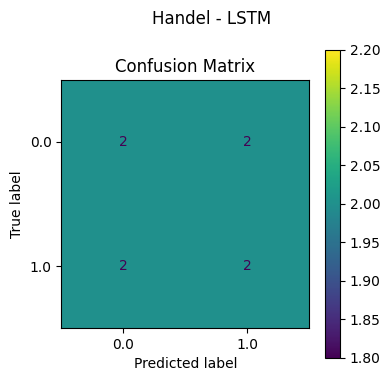

In [ ]:
# handel lstm - call function to build confusion matrix
handel_lstm_score_accuracy_train, handel_lstm_score_accuracy_test, handel_lstm_score_precision, handel_lstm_score_recall, handel_lstm_score_f1 = build_confusion_matrix(
    model=model_handel_lstm, description='Handel - LSTM', x_train=(x_train1, x_train2), x_test=(x_test1, x_test2), y_train=y_train, y_test=y_test)

## Hummel - CNN (Aria)

### Split Datasets

In [ ]:
# call function to build and split datasets
x_train, y_train, x_val, y_val, x_test, y_test = build_datasets_cnn(composer_name = 'hummel',
                                                                    composer_train = hummel_train,
                                                                    composer_val = hummel_dev,
                                                                    composer_test = hummel_test,
                                                                    feature_to_extract = 'chroma',
                                                                    feature_length = 2000)

# print input shape to go into cnn model
print('\nInput Shape for Training:')
print('x_train:', x_train.shape)

Begin processing TRAIN dataset:
Processing file 5 of 84.
Processing file 10 of 84.
Processing file 15 of 84.
Processing file 20 of 84.
Processing file 25 of 84.
Processing file 30 of 84.
Processing file 35 of 84.
Processing file 40 of 84.
Processing file 45 of 84.
Processing file 50 of 84.
Processing file 55 of 84.
Processing file 60 of 84.
Processing file 65 of 84.
Processing file 70 of 84.
Processing file 75 of 84.
Processing file 80 of 84.

Begin processing VAL dataset:
Processing file 5 of 8.

Begin processing TEST dataset:
Processing file 5 of 8.

Input Shape for Training:
x_train: (84, 12, 2000, 1)


### Build, Train, and Optimize

Epoch 1/25
3/3 [==============================] - 4s 2s/step - loss: 0.7181 - accuracy: 0.4643 - val_loss: 0.5503 - val_accuracy: 0.8750
Epoch 2/25
3/3 [==============================] - 1s 193ms/step - loss: 0.5418 - accuracy: 0.6905 - val_loss: 0.4809 - val_accuracy: 0.8750
Epoch 3/25
3/3 [==============================] - 1s 251ms/step - loss: 0.4078 - accuracy: 0.9048 - val_loss: 0.4939 - val_accuracy: 0.7500
Epoch 4/25
3/3 [==============================] - 1s 267ms/step - loss: 0.3540 - accuracy: 0.8929 - val_loss: 0.3759 - val_accuracy: 1.0000
Epoch 5/25
3/3 [==============================] - 1s 203ms/step - loss: 0.2756 - accuracy: 0.8810 - val_loss: 0.3401 - val_accuracy: 0.8750
Epoch 6/25
3/3 [==============================] - 1s 553ms/step - loss: 0.2203 - accuracy: 0.9524 - val_loss: 0.3849 - val_accuracy: 0.7500
Epoch 7/25
3/3 [==============================] - 1s 278ms/step - loss: 0.2218 - accuracy: 0.9405 - val_loss: 0.4280 - val_accuracy: 0.7500
Epoch 8/25
3/3 [=======

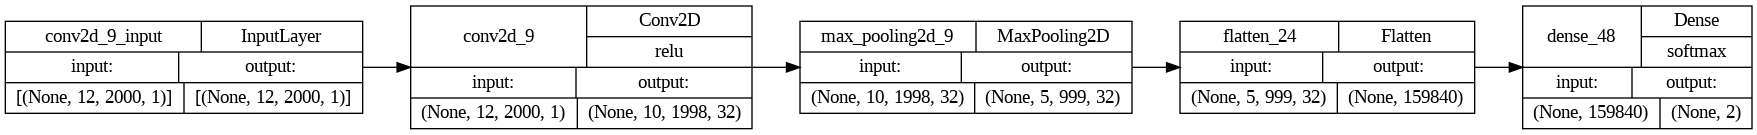

In [ ]:
# define input shape
input_shape = (x_train.shape[1], x_train.shape[2], x_train.shape[3])

# hummel cnn - define the cnn model
model_hummel_cnn = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(2, activation='softmax') # 2 units for binary classification using softmax
])

# hummel cnn - compile the model
model_hummel_cnn.compile(optimizer=Adam(learning_rate=0.001),
                         loss='sparse_categorical_crossentropy', # sparse categorical crossentropy loss function
                         metrics=['accuracy'])

# early stopping callback if learning stalls
callback = EarlyStopping(monitor='loss', patience=3)

# hummel cnn - train the model
model_hummel_cnn.fit(x_train, y_train, batch_size=32, epochs=25, callbacks=[callback], validation_data=(x_val, y_val))

# hummel cnn - evaluate the model on the test set
test_loss, test_acc = model_hummel_cnn.evaluate(x_test, y_test)
print('\nTest accuracy:', "{:.4%}".format(test_acc), '\n')

# plot model visualization
plot_model(model_hummel_cnn, to_file='model_hummel_cnn.png', show_shapes=True, rankdir='LR', show_layer_activations=True)

### Evaluate

8/8 [==============================] - 0s 4ms/step
Hummel - CNN 

Train Accuracy: 100.00%
Test Accuracy: 75.00%
Precision: 100.00%
Recall: 50.00%
F1 Score: 66.67%


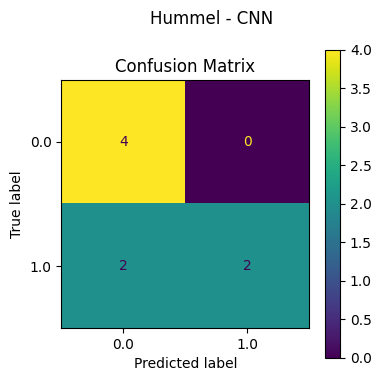

In [ ]:
# hummel cnn - call function to build confusion matrix
hummel_cnn_score_accuracy_train, hummel_cnn_score_accuracy_test, hummel_cnn_score_precision, hummel_cnn_score_recall, hummel_cnn_score_f1 = build_confusion_matrix(
    model=model_hummel_cnn, description='Hummel - CNN', x_train=x_train, x_test=x_test, y_train=y_train, y_test=y_test)

## Hummel - LSTM (Aria)

### Split Datasets

In [ ]:
# call function to build and split datasets
x_train1, x_train2, y_train, x_val1, x_val2, y_val, x_test1, x_test2, y_test = build_datasets_lstm(composer_name = 'hummel',
                                                                                                   composer_train = hummel_train,
                                                                                                   composer_val = hummel_dev,
                                                                                                   composer_test = hummel_test,
                                                                                                   num_sequences_beats = 16,
                                                                                                   num_sequences_pitch_class = 12,
                                                                                                   window_size_beats=15,
                                                                                                   window_size_pitch_class=12)

# print input shape to go into lstm model
print('\nInput Shapes for Training:')
print('x_train1:', x_train1.shape)
print('x_train2:', x_train2.shape)

Begin processing TRAIN dataset:
Processing file 5 of 84.
Processing file 10 of 84.
Processing file 15 of 84.
Processing file 20 of 84.
Processing file 25 of 84.
Processing file 30 of 84.
Processing file 35 of 84.
Processing file 40 of 84.
Processing file 45 of 84.
Processing file 50 of 84.
Processing file 55 of 84.
Processing file 60 of 84.
Processing file 65 of 84.
Processing file 70 of 84.
Processing file 75 of 84.
Processing file 80 of 84.

Begin processing VAL dataset:
Processing file 5 of 8.

Begin processing TEST dataset:
Processing file 5 of 8.

Input Shapes for Training:
x_train1: (84, 16, 15, 1)
x_train2: (84, 12, 12, 1)


### Build, Train, and Optimize

Epoch 1/25
3/3 [==============================] - 4s 640ms/step - loss: 0.6916 - accuracy: 0.5000 - val_loss: 0.6905 - val_accuracy: 0.5000
Epoch 2/25
3/3 [==============================] - 0s 23ms/step - loss: 0.6904 - accuracy: 0.5000 - val_loss: 0.6871 - val_accuracy: 0.5000
Epoch 3/25
3/3 [==============================] - 0s 134ms/step - loss: 0.6862 - accuracy: 0.5000 - val_loss: 0.6841 - val_accuracy: 0.5000
Epoch 4/25
3/3 [==============================] - 0s 22ms/step - loss: 0.6836 - accuracy: 0.5000 - val_loss: 0.6817 - val_accuracy: 0.5000
Epoch 5/25
3/3 [==============================] - 0s 22ms/step - loss: 0.6802 - accuracy: 0.5000 - val_loss: 0.6779 - val_accuracy: 0.5000
Epoch 6/25
3/3 [==============================] - 0s 21ms/step - loss: 0.6783 - accuracy: 0.5000 - val_loss: 0.6742 - val_accuracy: 0.5000
Epoch 7/25
3/3 [==============================] - 0s 23ms/step - loss: 0.6738 - accuracy: 0.5119 - val_loss: 0.6687 - val_accuracy: 0.5000
Epoch 8/25
3/3 [=========

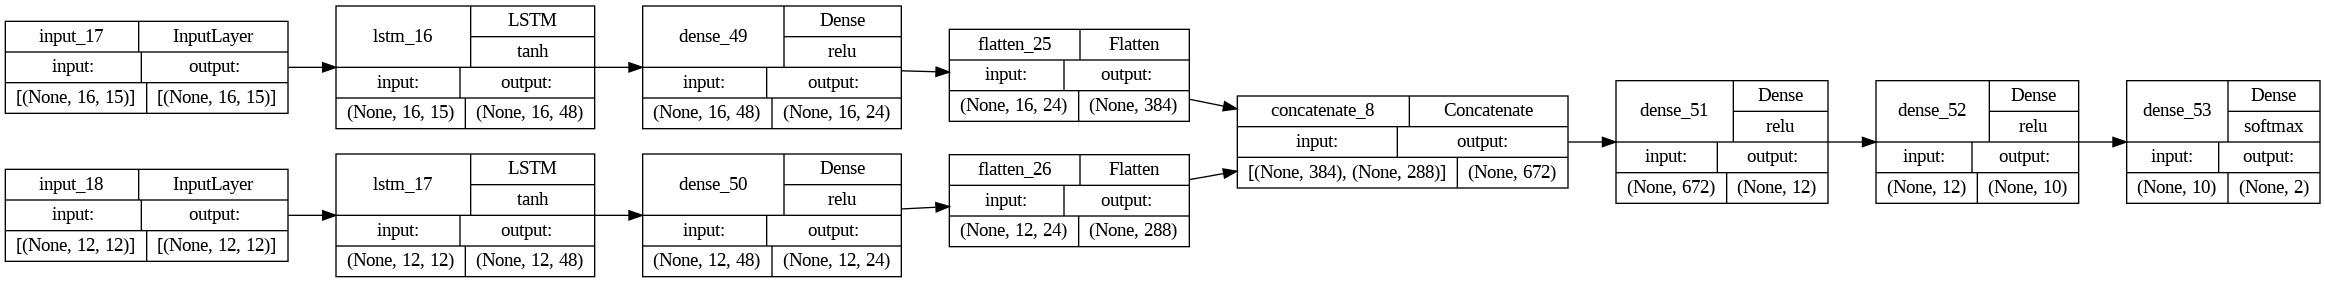

In [ ]:
# define input shapes for each feature
input_shape1 = (x_train1.shape[1], x_train1.shape[2]) # beats
input_shape2 = (x_train2.shape[1], x_train2.shape[2]) # pitch class

# define layers for first input - beats
input1 = Input(shape=(input_shape1))
lstm1 = LSTM(units=48, dropout=0.1, return_sequences=True)(input1)
dense1 = Dense(units=24, activation='relu')(lstm1)
flat1 = Flatten()(dense1)

# define layers for second input - pitch class
input2 = Input(shape=(input_shape2))
lstm2 = LSTM(units=48, dropout=0.1, return_sequences=True)(input2)
dense2 = Dense(units=24, activation='relu')(lstm2)
flat2 = Flatten()(dense2)

# concatenate inputs/layers together
inputs_concat = Concatenate(axis=1)([flat1, flat2])

# build remainder layers to output
dense3 = Dense(12, activation='relu')(inputs_concat)
dense4 = Dense(10, activation='relu')(dense3)
output = Dense(2, activation='softmax')(dense4)

# construct model
model_hummel_lstm = Model(inputs=[input1, input2], outputs=output)

# hummel lstm - compile the model
model_hummel_lstm.compile(
              optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy', # sparse categorical crossentropy loss function
              metrics=['accuracy'])

# early stopping callback if learning stalls
callback = EarlyStopping(monitor='loss', patience=3)

# hummel lstm - train the model
model_hummel_lstm.fit((x_train1, x_train2), y_train, batch_size=32, epochs=25, callbacks=[callback], validation_data=((x_val1, x_val2), y_val))

# hummel lstm - evaluate the model on the test set
test_loss, test_acc = model_hummel_lstm.evaluate((x_test1, x_test2), y_test)
print('\nTest accuracy:', "{:.4%}".format(test_acc), '\n')

# plot model visualization
plot_model(model_hummel_lstm, to_file='model_hummel_lstm.png', show_shapes=True, rankdir='LR', show_layer_activations=True)

### Evaluate

8/8 [==============================] - 0s 50ms/step
Hummel - LSTM 

Train Accuracy: 70.24%
Test Accuracy: 75.00%
Precision: 66.67%
Recall: 100.00%
F1 Score: 80.00%


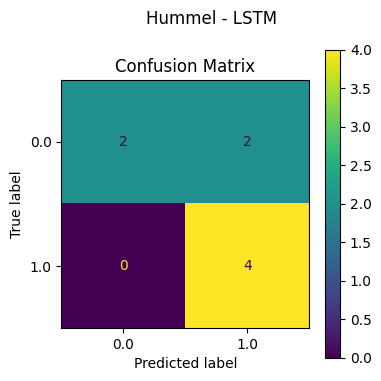

In [ ]:
# hummel lstm - call function to build confusion matrix
hummel_lstm_score_accuracy_train, hummel_lstm_score_accuracy_test, hummel_lstm_score_precision, hummel_lstm_score_recall, hummel_lstm_score_f1 = build_confusion_matrix(
    model=model_hummel_lstm, description='Hummel - LSTM', x_train=(x_train1, x_train2), x_test=(x_test1, x_test2), y_train=y_train, y_test=y_test)